In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import sys
sys.path.append('/Users/urebbapr/research/opticalcomm/MLOC/src')

from functools          import partial
from matplotlib.patches import Patch
from matplotlib.ticker  import FormatStrFormatter
from types              import SimpleNamespace as SN

# Depending on how your environment is setup, may need to tweak the utils import
from utils import (
    load_weather,
    load_bls,
    load_r0,
    load_pwv
)

# Disable warnings
warnings.filterwarnings('ignore')

# Disable logger except for errors/exceptions
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Set context of seaborn
sns.set_context('talk')


In [2]:
# SET THESE VARIABLES BEFORE EXECUTING THE FUNCTIONS
# Do not remove any variable, leave them as default if unsure. Follow the instructions if provided.
config = SN(
    # Select the dataset and provide the path to the data directory
    name = 'pwv',       # Options: ['weather', 'bls', 'r0_day', 'r0_night']
    path = '../../data/v3/PVWwithWeather.txt',
    # Expected files:
    # bls         : BLS1820B.mat
    # r0_daytime  : fl4.mat
    # r0_nighttime: Cyclop1820.mat
    # pwv: PVWwithWeather.txt

    # Enable plots to save to the given dir
    save = True,
    dir  = '../plots/pwv/',

    # Enable plots; see the lower sections of the config to know
    plots = SN(
        vc    = True,   # Time cadence graphs       # Disables both the global and the per-column cadence graphs
        davg  = True,   # Daily average graphs      #
        heat  = True,   # Correlation heatmaps      # Disables both the value and nan correlation heatmaps
        hists = True,   # Sigma histograms          #
        dvt   = True    # Data vs Time scatterplot  # This plot can take awhile to generate, may want to disable if you're running analysis() a lot
    ),

    ## Additional arguments for tweaking plot generations, defaults generally apply to all datasets
    # Args for value_count bar plots
    vc = SN(
        kind    = 'bar',
        title   = 'Distance between Timestamps for {type}', # Optional flags [{type}], type=[config.name, col]
        ylabel  = 'Count',
        logy    = True,
        figsize = (30, 10), # width, height
        limits  = (25, 25), # (N, M), plots the first N and last M values, eg. values[:N] + values[-M:]
        file    = 'time_cadence_{type}.png', # Optional flags [{type}], type=[config.name, col]
        #overrides = {}
    ),

    # Args for daily average plots
    davg = SN(
        alpha   = 1,
        figsize = (30, 10),
        xlabel  = 'Day of the Year',
        ylabel  = 'Value',
        title   = 'Daily Average Value for {col}',  # Optional flags [{col}], col=df.col
        file    = 'daily_average_{col}.png',        # Optional flags [{col}], col=df.col
        overrides = {
            'bls': {
                'logy': True
            }
        }
    ),

    # Args for the correlation heatmaps
    heat = SN(
        method  = 'pearson',    # Pandas df.corr(method=)
        annot   = True,         # Annotates the graph with values in the correlation squares
        vmin    = -1,           # Minimum value
        vmax    = 1,
        cmap    = 'RdYlBu',     # Colouring gradient from vmin to vmax
        square  = True,         # Makes the correlation squares actually square (False may make them different shaped rectangles)
        figsize = (15, 15),
        file    = '{type}_correlations.png', # Optional flags [{type}], type=['value', 'nan']
        title   = 'Correlation of {type} for {name}', # Optional flags [{name}, {type}], type=['Values', 'NaNs']
        #override = {}
    ),

    # Args for the sigma histograms
    hists = SN(
        bins  = 109,        # Weather has weird spikes in the bins when N < 109
        alpha = 0.3,        # The opacity of the regions, higher is greater opacity
        logy  = True,
        ylabel = 'Value Count',
        xlabel = 'Value',
        title  = 'Histogram of {col}, bins={bins}', # Optional flags: [{col}, {bins}]
        file   = 'sigma_hist_{col}.png',            # Optional flags: [{col}]
        sigmas = {          # Sigma regions to highlight and their corresponding colours
            3: 'red',
            4: 'orange',
            5: 'yellow',
            6: 'green',
            7: 'blue'
        },
        colors = SN(        # Sets the colours of the vertical lines at specific points
            mean = 'red',
            min  = 'black',
            max  = 'black',
            hist = 'grey'   # Colour of the histogram itself
        ),
        normalize = False,  # Normalizes the dataframe columns prior to plotting
        loc       = 'upper right',  # Location of the legend
        figsize   = (20, 10),
        #overrides = {}
    ),

    # Args for the data vs time plot
    dvt = SN(
        figsize   = (30, 10),
        alpha     = 0.7,
        ylabel    = 'Value',
        title     = 'Data vs Time for {name}',  # Optional flags [{name}], name=config.name
        marker    = '+',
        normalize = True,   # Normalizes the dataframe columns prior to plotting
        file      = 'scatter_data_vs_time.png',
        #overrides = {}
    )
)

# View the config object
#config


In [3]:
def show(save='please_set_a_name.png'):
    """
    Shows a plot, saves it if set
    """
    plt.tight_layout()

    if config.save:
        plt.savefig(f'{config.dir}/{save}')

    plt.show()
    plt.clf()

def data_vs_time(df):
    """
    Plots all the data on a single scatterplot
    """
    if config.dvt.normalize:
        df = (df - df.mean()) / (df.max() - df.min())

    _, ax = plt.subplots(figsize=config.dvt.figsize)
    for col in df:
        sns.scatterplot(
            x      = df.index.values,
            y      = df[col],
            label  = col,
            ax     = ax,
            marker = config.dvt.marker,
            alpha  = config.dvt.alpha
        )

    ax.set_ylabel(config.dvt.ylabel)
    ax.set_title(config.dvt.title.format(name=config.name))

    show(config.dvt.file)

def sigma_hist(col, series, n_bins=109, save=False):
    """
    Generates a histogram for the provided column and highlights the sigma
    regions.
    """
    ticks = set()
    if config.hists.normalize:
        series = (series - series.mean()) / (series.max() - series.min())

    # Gather stats
    min  = series.min()
    max  = series.max()
    mean = series.mean()
    std  = series.std()

    # Create the histogram
    ax = series.hist(
        bins    = config.hists.bins,
        log     = config.hists.logy,
        color   = config.hists.colors.hist,
        figsize = config.hists.figsize
    )

    # Highlight the sigma regions
    legend = []
    for sigma, colour in config.hists.sigmas.items():
        lower_x2, upper_x1 = (mean - sigma * std, mean + sigma * std)
        lower_x1, upper_x2 = (mean - (sigma + 1) * std, mean + (sigma + 1) * std)

        added = False
        if min < lower_x2:
            ax.axvspan(lower_x1, lower_x2, color=colour, alpha=0.3)
            ticks.add(lower_x1); ticks.add(lower_x2)
            added = True
        if upper_x1 < max:
            ax.axvspan(upper_x1, upper_x2, color=colour, alpha=0.3)
            ticks.add(upper_x1); ticks.add(upper_x2)
            added = True

        if added:
            legend.append(Patch(facecolor=colour, label=f'{sigma}σ', alpha=.3, edgecolor='black'))

    # Plot the stddev
    ax.axvspan(mean, mean, color=config.hists.colors.mean)
    ax.axvspan( min,  min, color=config.hists.colors.min )
    ax.axvspan( max,  max, color=config.hists.colors.max )

    # Change the x-axis ticks to be meaningful
    # Change lower x-ticks to the sigma values
    ticks.add(mean)
    ax.set_xticks(list(ticks), minor=False)

    # Add an upper x-ticks for min/max values
    ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    ax.tick_params(which='minor', length=0, labeltop=True, labelbottom=False, top=True)
    ax.set_xticks([min, max], minor=True)

    # Remove vertical lines from the grid
    ax.grid(axis='x', b=False)

    # Set some texts
    ax.set_title(config.hists.title.format(col=col, bins=config.hists.bins))
    ax.set_ylabel(config.hists.ylabel)
    ax.set_xlabel(config.hists.xlabel)

    if legend:
        ax.legend(handles=legend, loc=config.hists.loc)

    show(config.hists.file.format(col=col))

def time_cadence(df):
    """
    Plots the time cadence of a dataframe, assumes the index is a DateTimeIndex
    """
    flags = {
        'kind'   : config.vc.kind,
        'title'  : config.vc.title.format(type=config.name),
        'ylabel' : config.vc.ylabel,
        'xlabel' : 'Cadence (time delta)',
        'logy'   : config.vc.logy,
        'figsize': config.vc.figsize
    }

    first   = df.index[0]
    last    = df.index[-1]
    cadence = df.index.to_series().diff().shift(-1)
    mean    = cadence.mean()

    print(f'There are {df.index.size} rows of timestamps ranging from {first} to {last}.')
    print(f'For this range, the average cadence was {mean}.')

    if config.plots.vc:
        print('Below is a graph showing other differences in cadences discovered.\n')

        valcou = cadence.value_counts().sort_index()

        front, back = config.vc.limits
        if valcou.size > front+back:
            valcou = pd.concat([valcou[:front], valcou[-back:]])

        ax = valcou.plot(**flags)
        show(config.vc.file.format(type=config.name))

    return first, last, mean

def daily_average(col, series):
    """
    Plots the daily average value of each year for a given series
    """
    override = config.davg.overrides.get(config.name, {})

    print('\nThe following graph plots the daily average of each year:\n')

    _, ax = plt.subplots(figsize=config.davg.figsize)

    daily = series.resample('1D').mean()    # Take the mean of each day
    years = pd.date_range(
        f'{series.index[0].year}/1/1',      # From the start of the year of the first timestamp
        f'{series.index[-1].year+1}/1/1',   # To the start of the next year after the last timestamp
        freq = '1Y',
        normalize = True
    )
    for i, year in enumerate(years):
        if i == 0:
            data = daily[daily.index <= year]
        else:
            data = daily[(daily.index > years[i-1]) & (daily.index <= year)]

        # Reset the index to day of year to remove the year, and plot
        data.index = data.index.dayofyear
        ax = data.plot(
            label = year.year,
            ax    = ax,
            alpha = config.davg.alpha,
            **override
        )

    ax.legend()
    ax.set_title(config.davg.title.format(col=col))
    ax.set_xlabel(config.davg.xlabel)
    ax.set_ylabel(config.davg.ylabel)

    show(config.davg.file.format(col=col))

def analyze(df, drop=True):
    """
    Analyzes a provided dataframe with some generic statistics

    Assumptions:
    - The index is dtype DateTime

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to perform analysis on
    drop : bool
        Drops rows that are entirely null value, eg. resampling the dataframe
        can cause new rows to be inserted
    """
    stats = {
        'time'   : {},
        'values' : {},
        'nans'   : {},
        'columns': {}
    }

    # Some integrity checks
    assert df.index.is_all_dates
    df = df.sort_index()

    # Drop rows that are entirely empty
    if drop:
        df = df.dropna(axis=0, how='all')

    # Plot all the data
    if config.plots.dvt:
        data_vs_time(df)

    # Time analysis
    stats['time']['first'], stats['time']['last'], stats['time']['mean'] = time_cadence(df)

    # Value analysis
    stats['values']['totals'] = (~df.isna()*1).sum()
    print(f"\nThe total values for each column are as follows:\n{stats['values']['totals']}")

    if config.plots.heat:
        print(f'\nThe correlation of these values between columns are provided in the following heatmap:\n')
        _, ax = plt.subplots(figsize=config.heat.figsize)
        ax = sns.heatmap(
            df.corr(method=config.heat.method),
            annot  = config.heat.annot,
            vmin   = config.heat.vmin,
            vmax   = config.heat.vmax,
            cmap   = config.heat.cmap,
            square = config.heat.square,
            ax     = ax

        )
        ax.set_title(config.heat.title.format(name=config.name, type='Values'))
        show(config.heat.file.format(type='value'))

    ## NaN analysis
    nandf   = df.isna() * 1 # Converts bools to binary
    nancorr = nandf.corr(method=config.heat.method)
    stats['nans']['totals'] = nandf.sum()

    print(f"The total NaNs for each column are as follows:\n{stats['nans']['totals']}")
    if nancorr.any().any() and config.plots.heat:
        print(f'\nThe correlation of the positions of these nans between columns are provided in the following heatmap:\n')

        _, ax = plt.subplots(figsize=config.heat.figsize)
        ax = sns.heatmap(
            nancorr,
            annot  = config.heat.annot,
            vmin   = config.heat.vmin,
            vmax   = config.heat.vmax,
            cmap   = config.heat.cmap,
            square = config.heat.square,
            ax     = ax
        )
        ax.set_title(config.heat.title.format(name=config.name, type='NaNs'))
        show(config.heat.file.format(type='nan'))

    ### Per column analysis
    for col in df.columns:
        print(f'\nANALYZING {col}')
        stats['columns'][col] = {}
        series = df[col]

        # Distance between values
        valinds = series[~series.isna()].index.to_series()
        cadence = valinds.diff().shift(-1)
        valcou  = cadence.value_counts().sort_index()

        stats['columns'][col]['percent']      = (valinds.size / series.size) * 100
        stats['columns'][col]['total']        = series.size
        stats['columns'][col]['value count']  = valinds.size
        stats['columns'][col]['nan count']    = series.size - valinds.size
        stats['columns'][col]['cadence mean'] = cadence.mean()

        print(f"The column is {stats['columns'][col]['percent']:.2f}% dense, {valinds.size} / {series.size}")
        print(f"The average distance between values is {stats['columns'][col]['cadence mean']}.")

        if config.plots.vc:
            print(' Below is a graph showing the various differences in distances between values:\n')

            flags = {
                'kind'   : config.vc.kind,
                'title'  : config.vc.title.format(type=col),
                'ylabel' : config.vc.ylabel,
                'xlabel' : 'Time Delta between Values',
                'logy'   : config.vc.logy,
                'figsize': config.vc.figsize
            }
            front, back = config.vc.limits
            if valcou.size > front+back:
                valcou = pd.concat([valcou[:front], valcou[-back:]])

            ax = valcou.plot(**flags)
            show(config.vc.file.format(type=col))

        if config.plots.davg:
            daily_average(col, series)

        # Outliers
        if config.plots.hists:
            print('\nThe follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.')
            print('The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.')
            print('The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.')
            sigma_hist(col, series)

    return stats


In [4]:
loader = lambda: pd.DataFrame()
if config.name is 'weather':
    loader = partial(load_weather, interpolate=False)
elif config.name is 'bls':
    loader = partial(load_bls, datenum=True, round=True, drop_dups=True)
elif config.name is 'r0_day':
    loader = partial(load_r0, kind='day', datenum=True, round=True)
elif config.name is 'r0_night':
    loader = partial(load_r0, kind='night', datenum=True, round=True)
elif config.name is 'pwv':
    loader = partial(load_pwv, datenum=True, round=True)
df = loader(path=config.path)

if df.empty:
    print('Error! The dataframe is empty!')


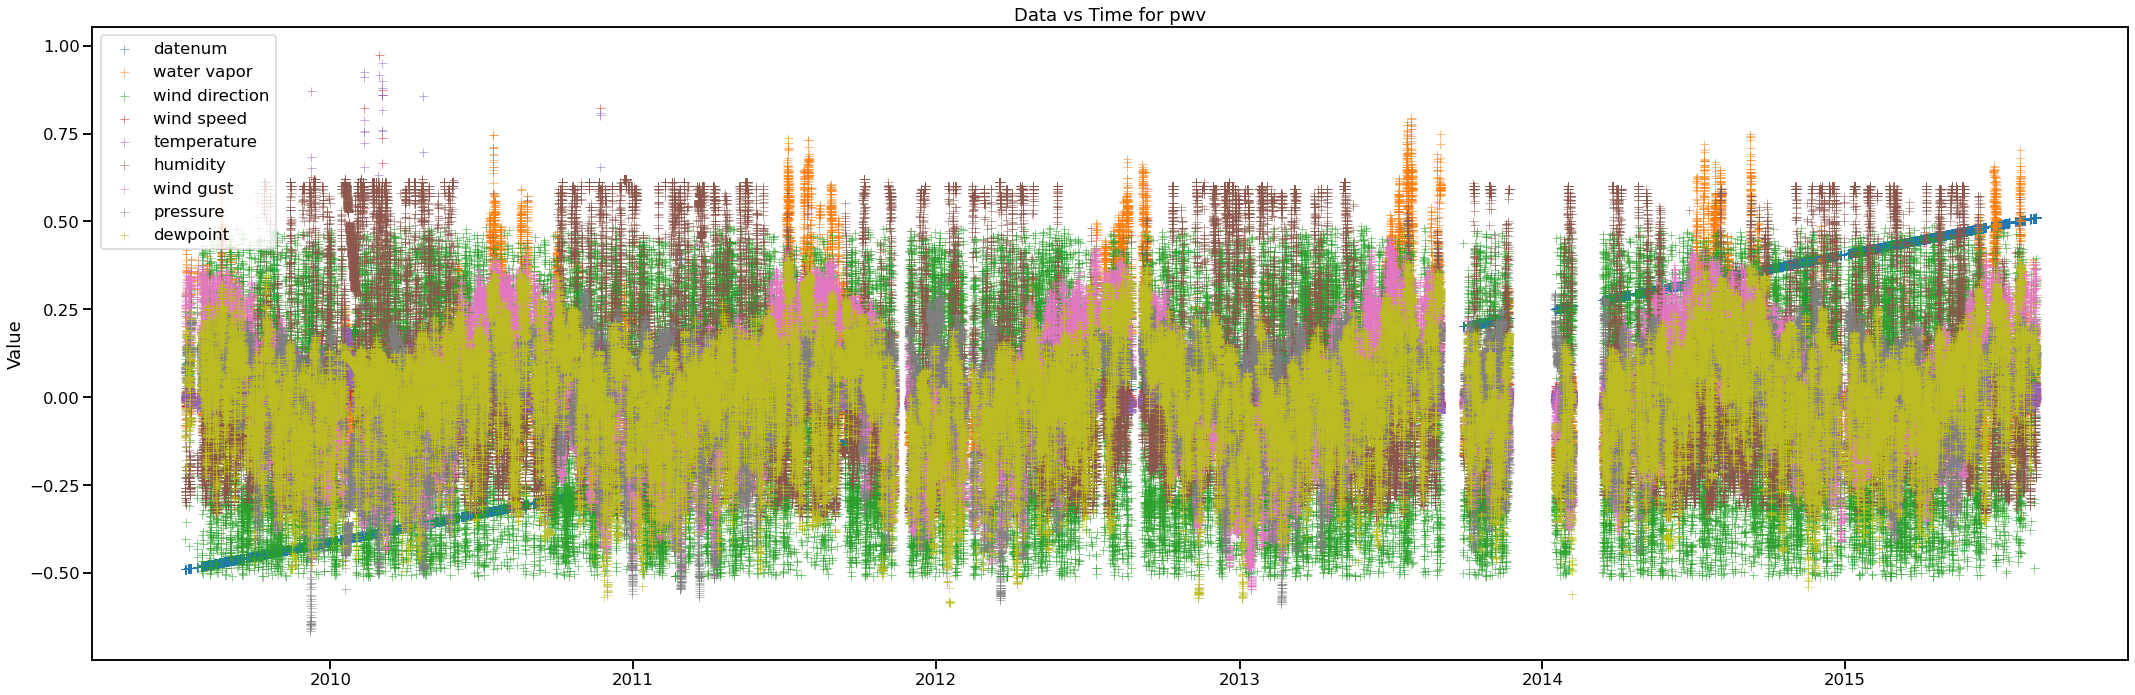

There are 91368 rows of timestamps ranging from 2009-07-09 14:45:36 to 2015-08-18 20:45:36.
For this range, the average cadence was 0 days 00:35:09.952170915.
Below is a graph showing other differences in cadences discovered.



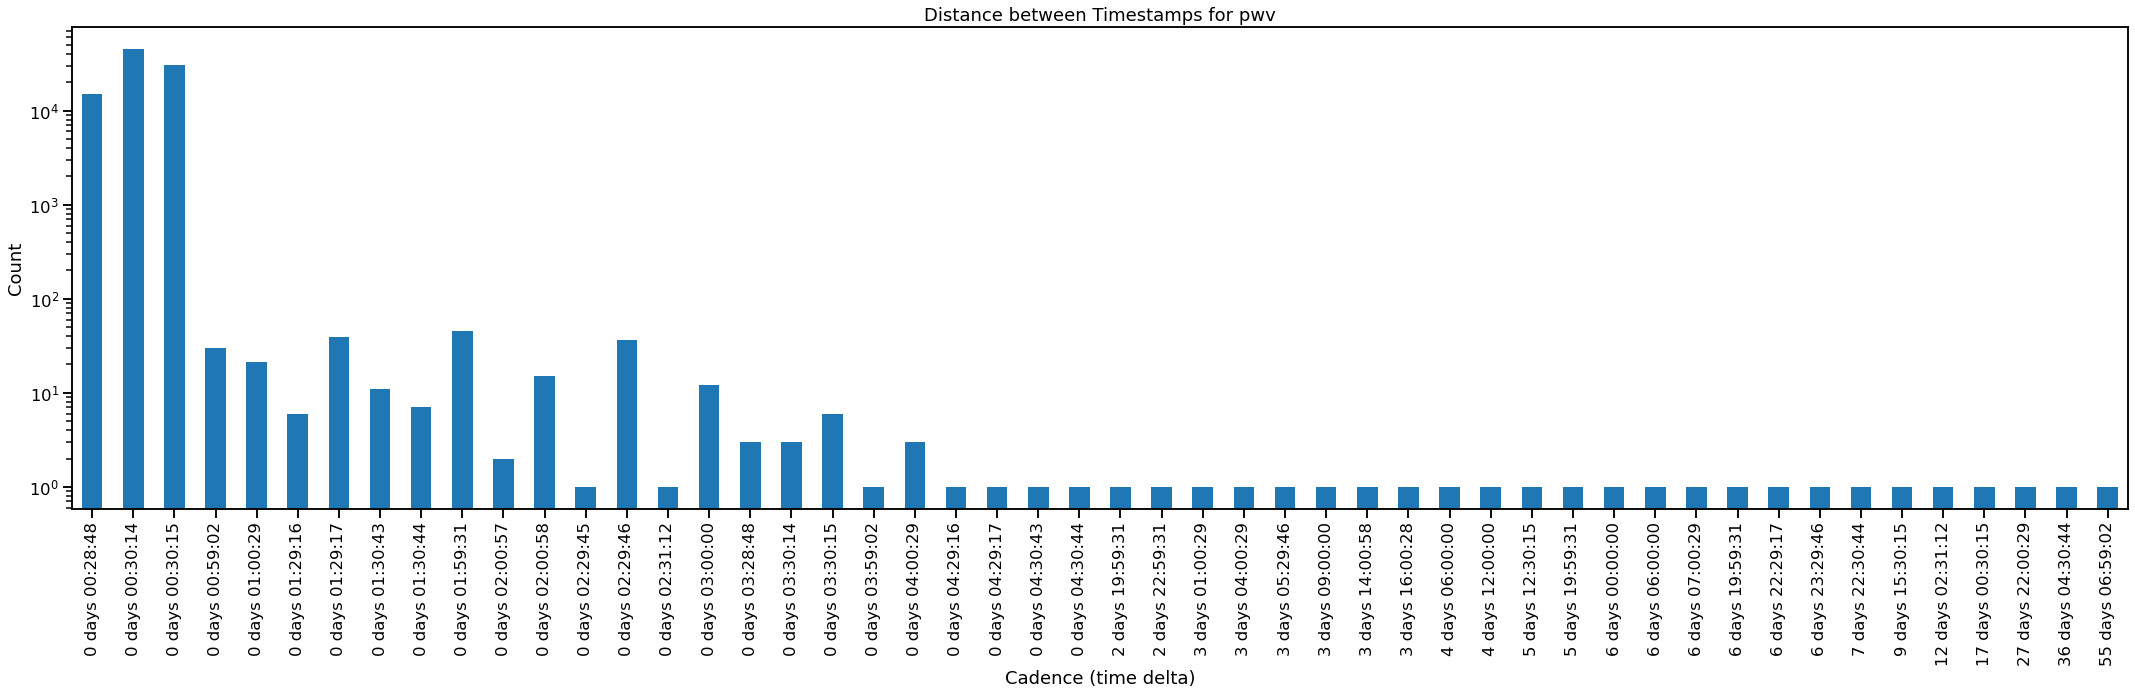


The total values for each column are as follows:
datenum           91368
water vapor       91368
wind direction    91368
wind speed        91368
temperature       91368
humidity          91368
wind gust         91368
pressure          91368
dewpoint          91367
dtype: int64

The correlation of these values between columns are provided in the following heatmap:



<Figure size 432x288 with 0 Axes>

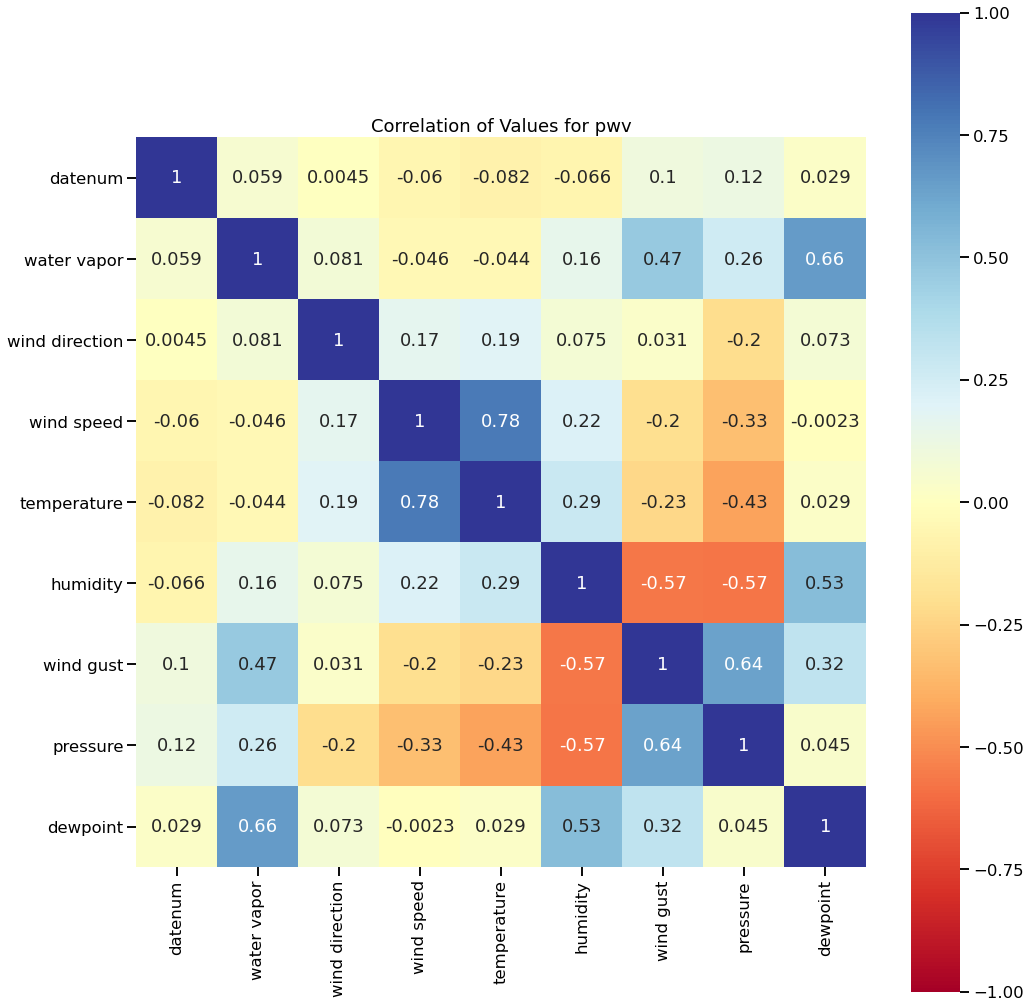

The total NaNs for each column are as follows:
datenum           0
water vapor       0
wind direction    0
wind speed        0
temperature       0
humidity          0
wind gust         0
pressure          0
dewpoint          1
dtype: int64

The correlation of the positions of these nans between columns are provided in the following heatmap:



<Figure size 432x288 with 0 Axes>

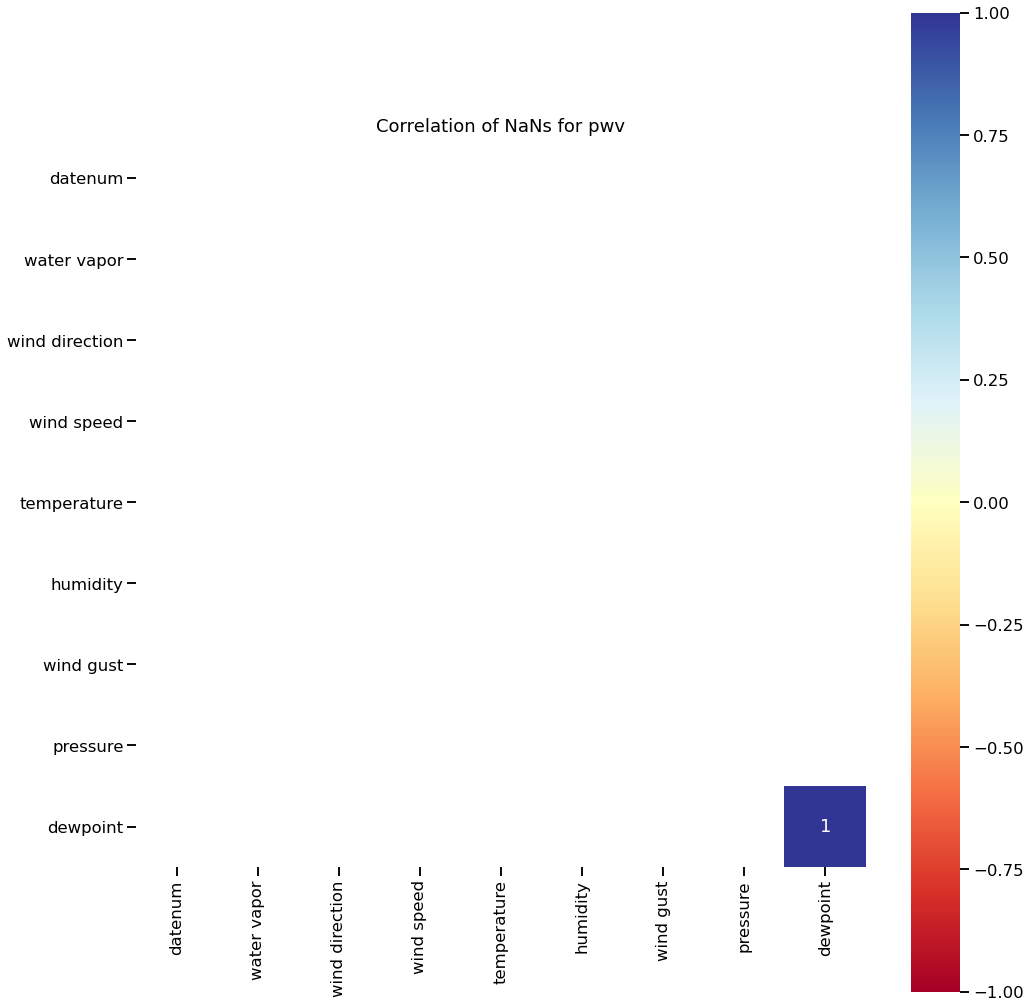


ANALYZING datenum
The column is 100.00% dense, 91368 / 91368
The average distance between values is 0 days 00:35:09.952170915.
 Below is a graph showing the various differences in distances between values:



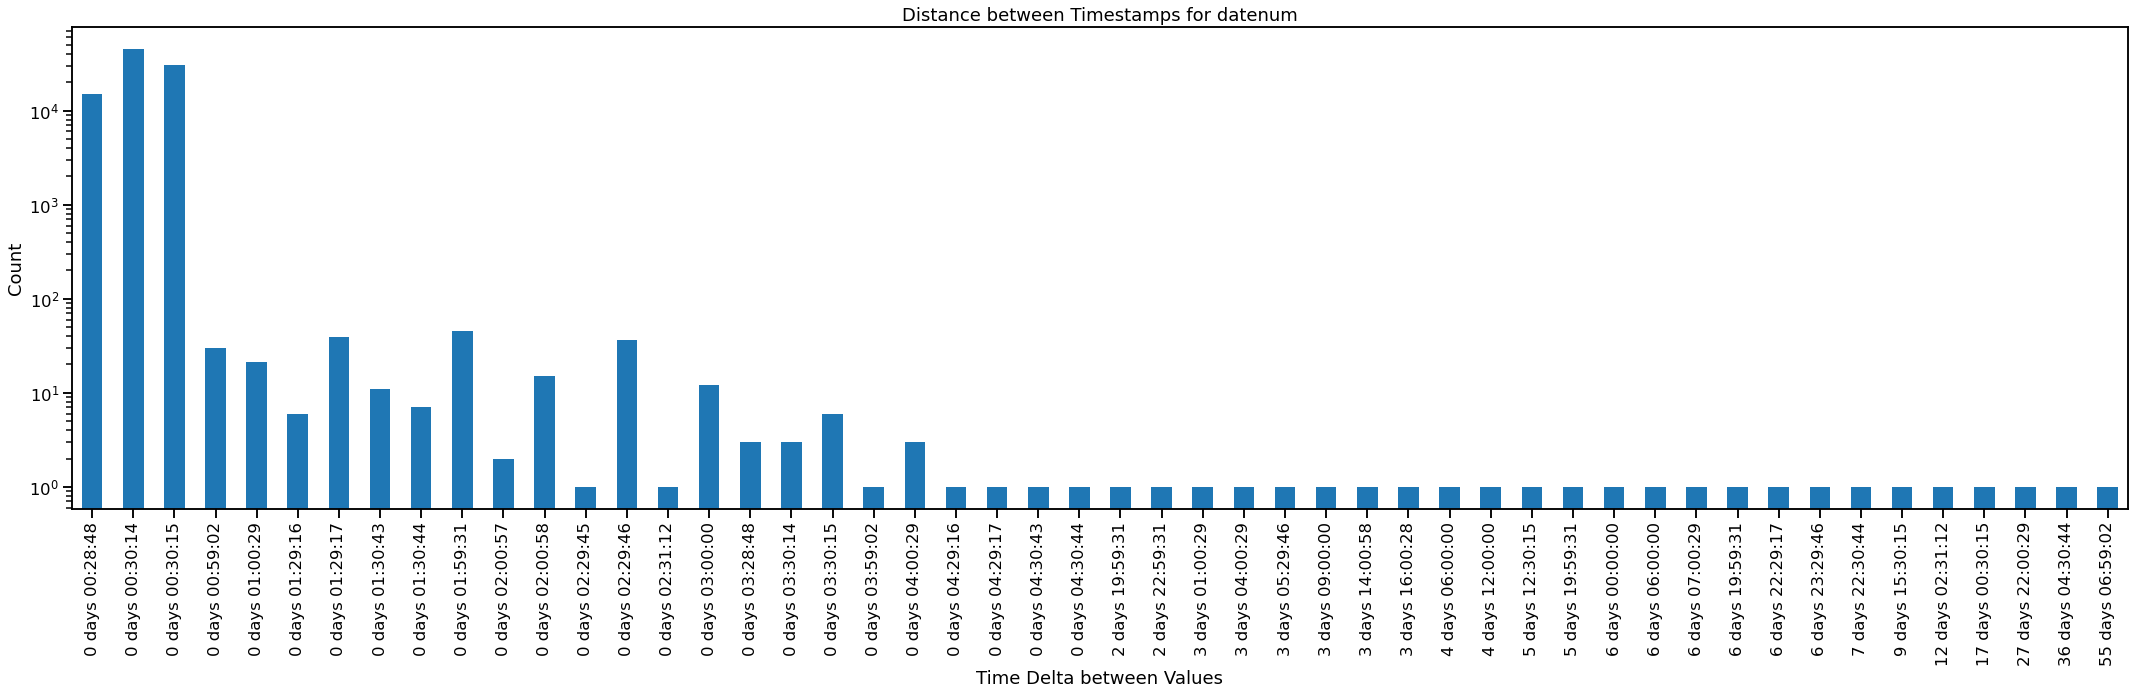


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

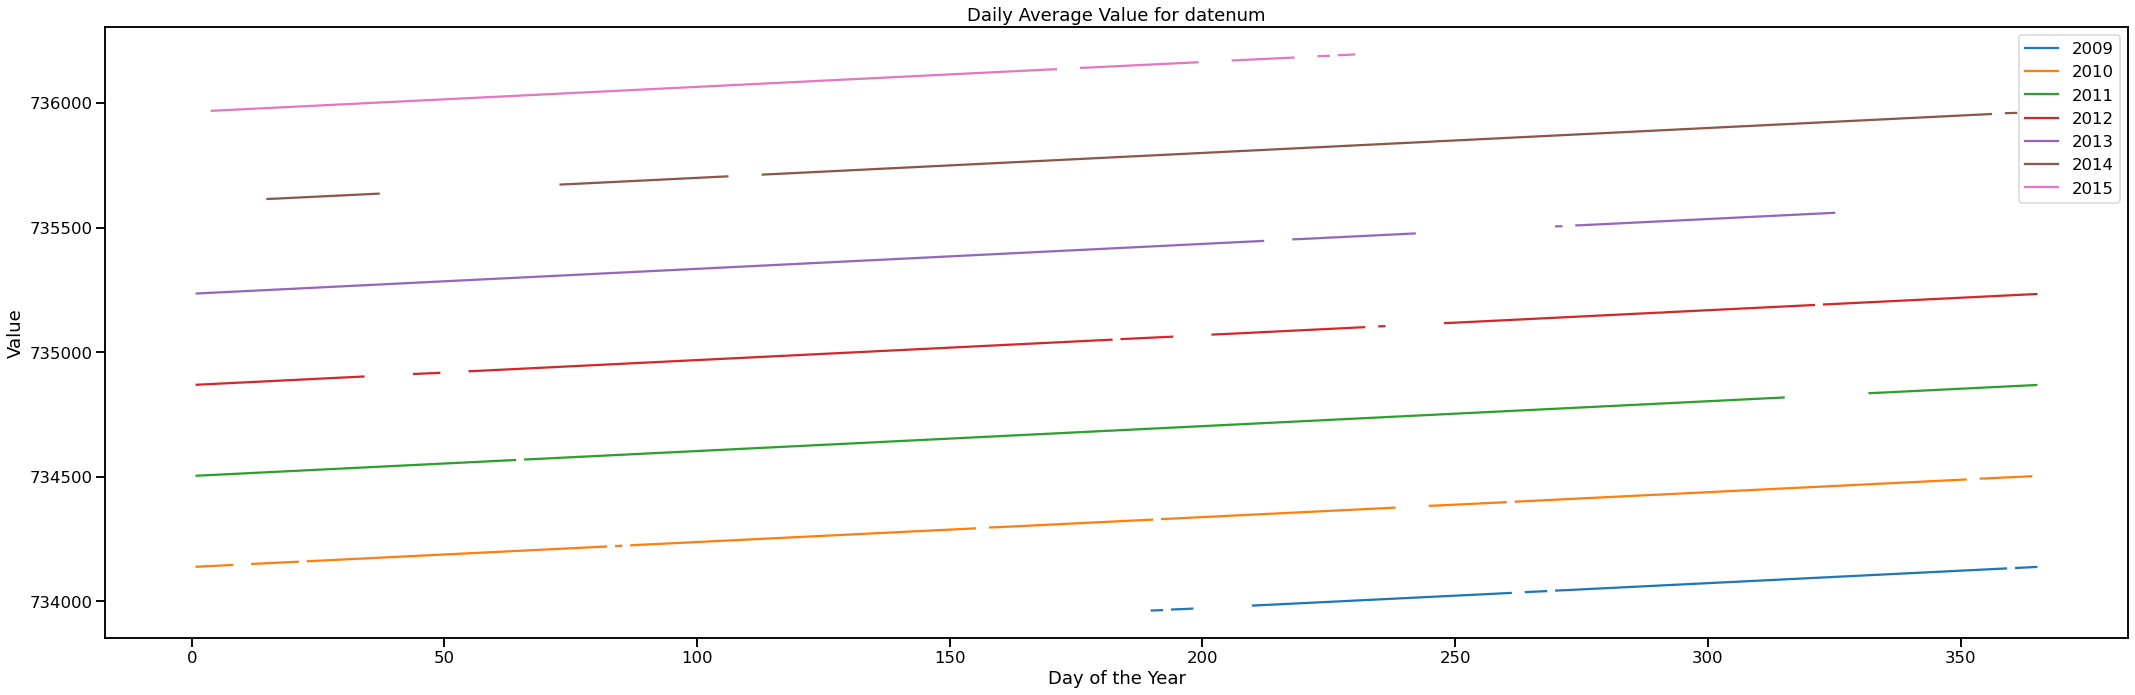


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


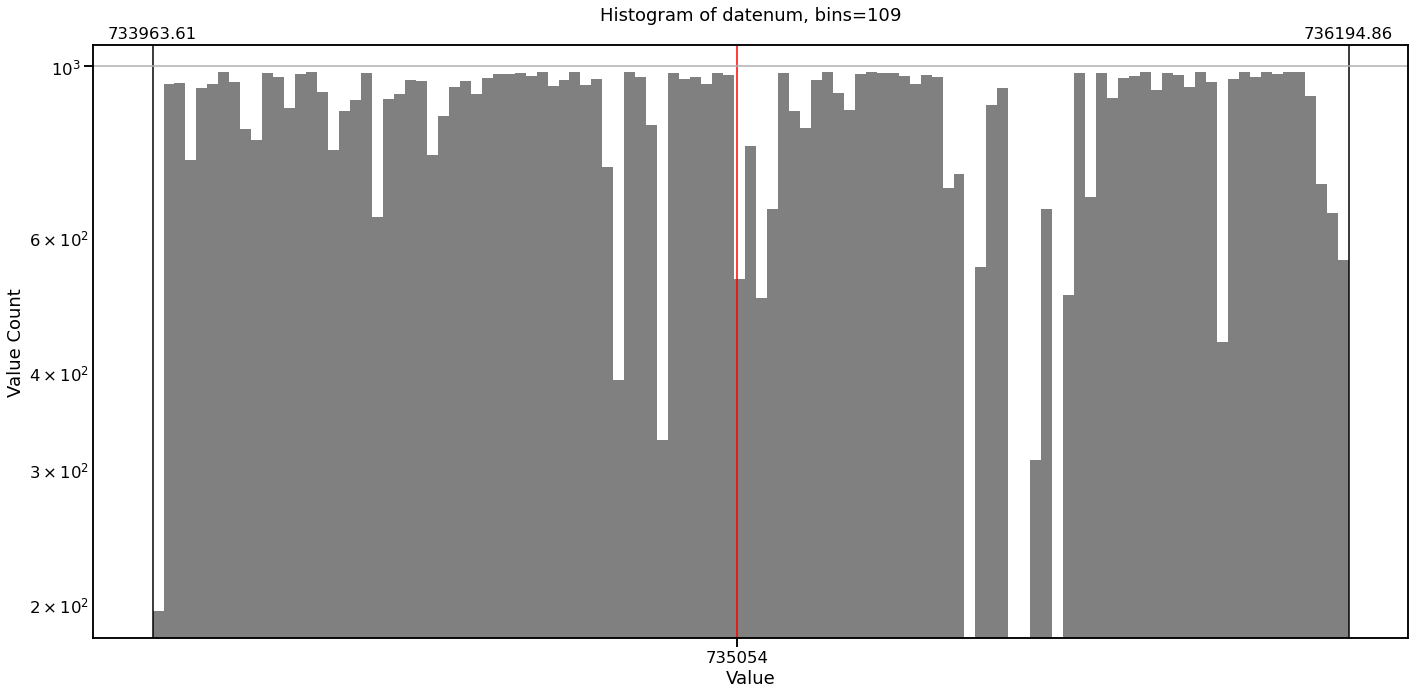


ANALYZING water vapor
The column is 100.00% dense, 91368 / 91368
The average distance between values is 0 days 00:35:09.952170915.
 Below is a graph showing the various differences in distances between values:



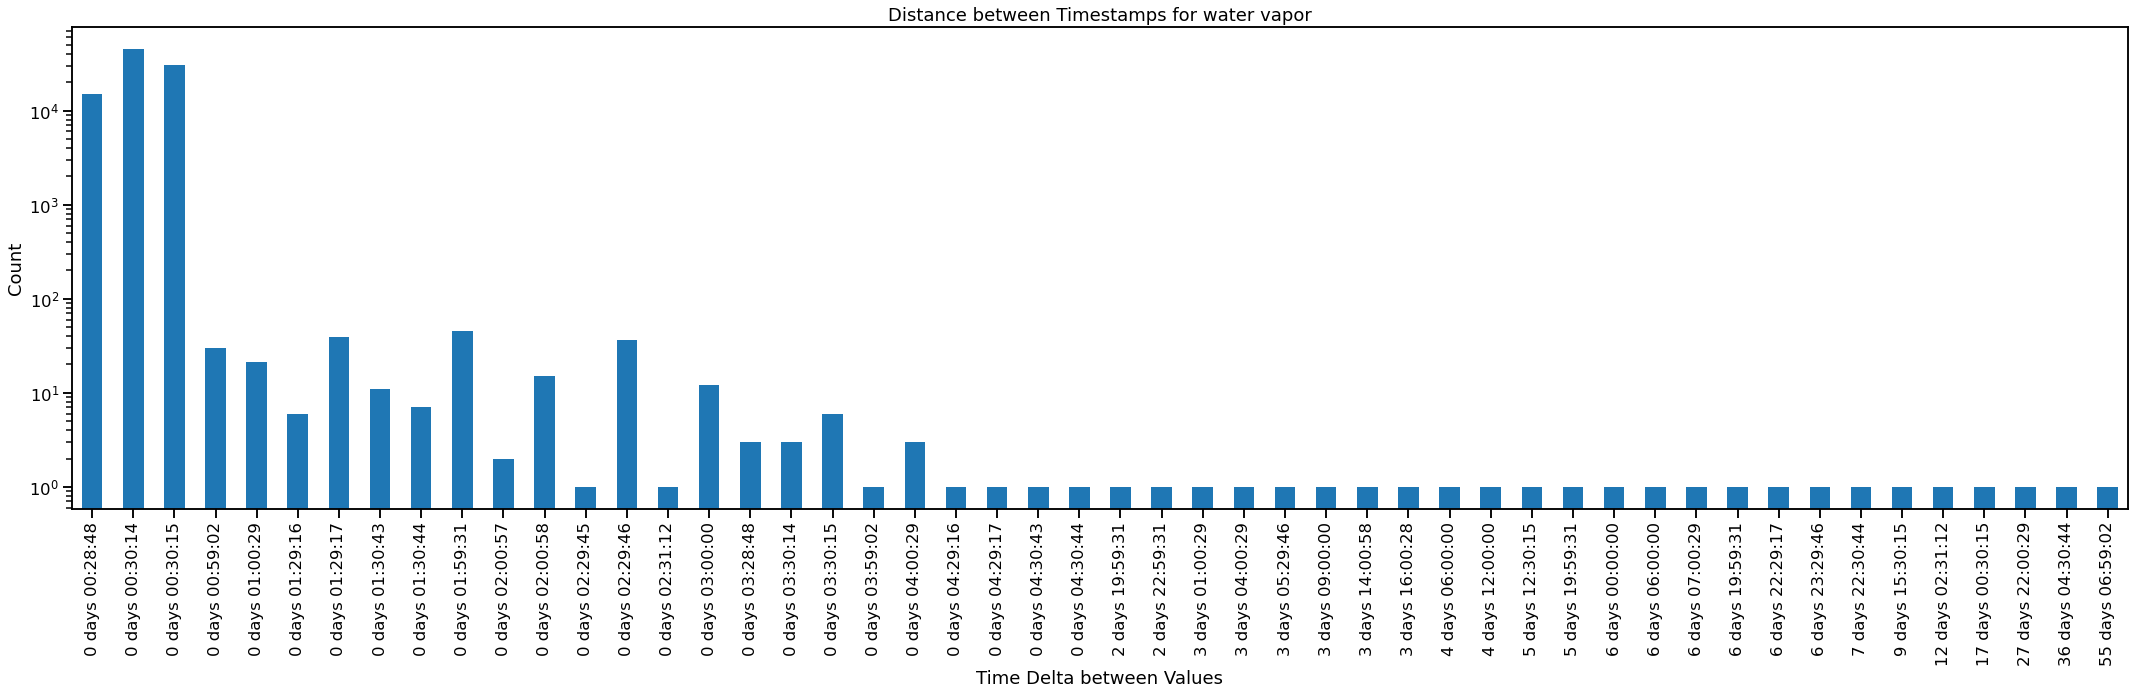


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

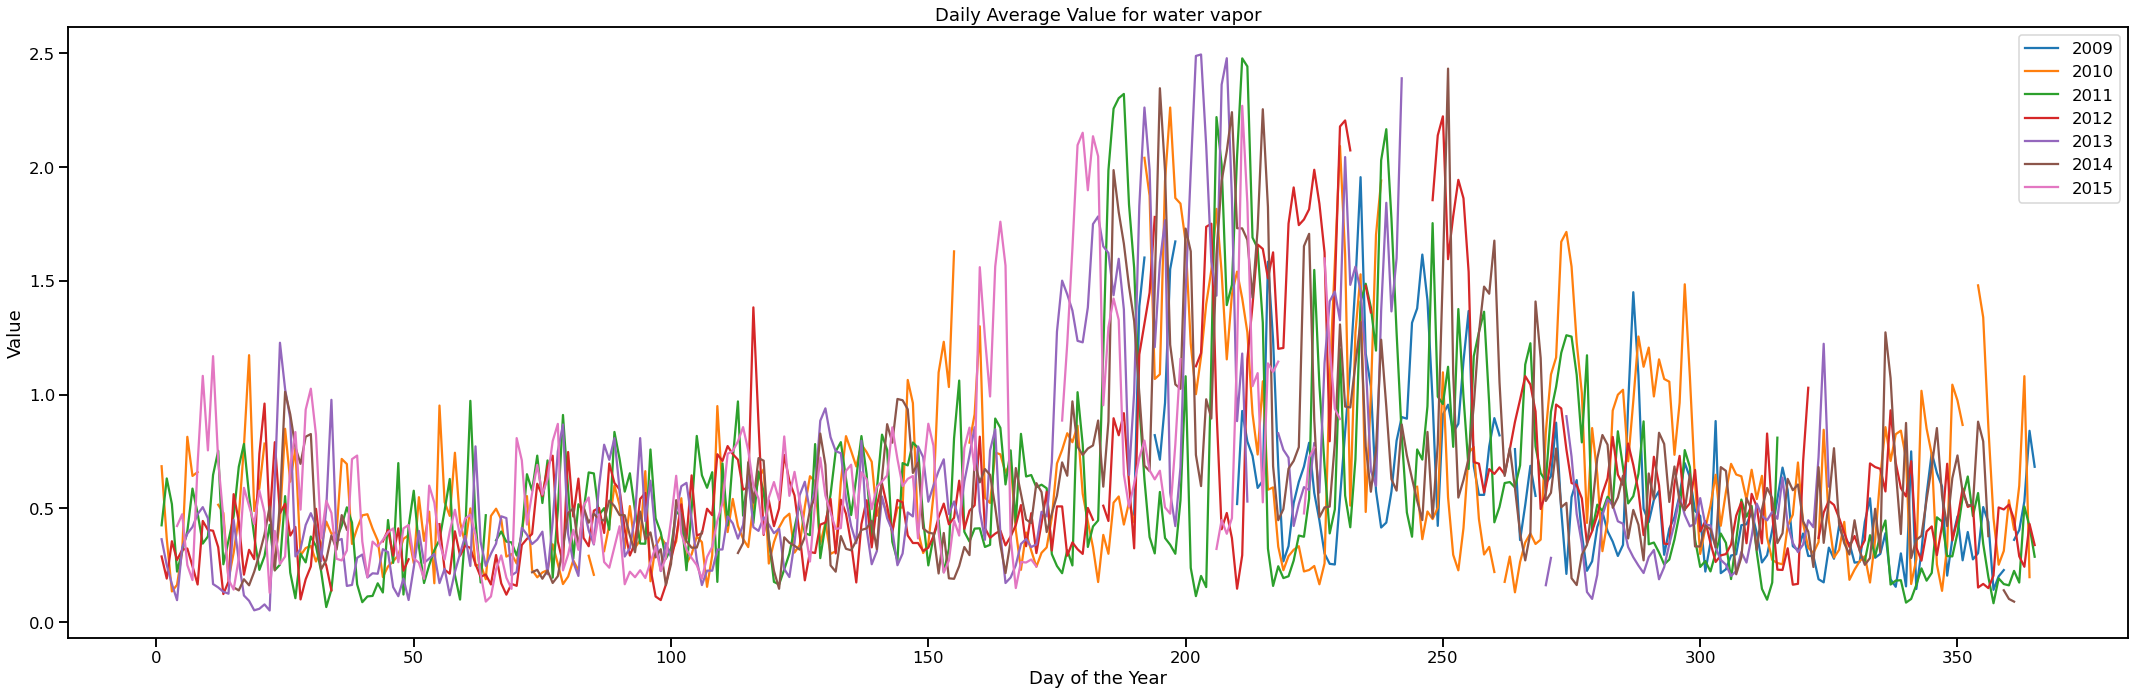


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


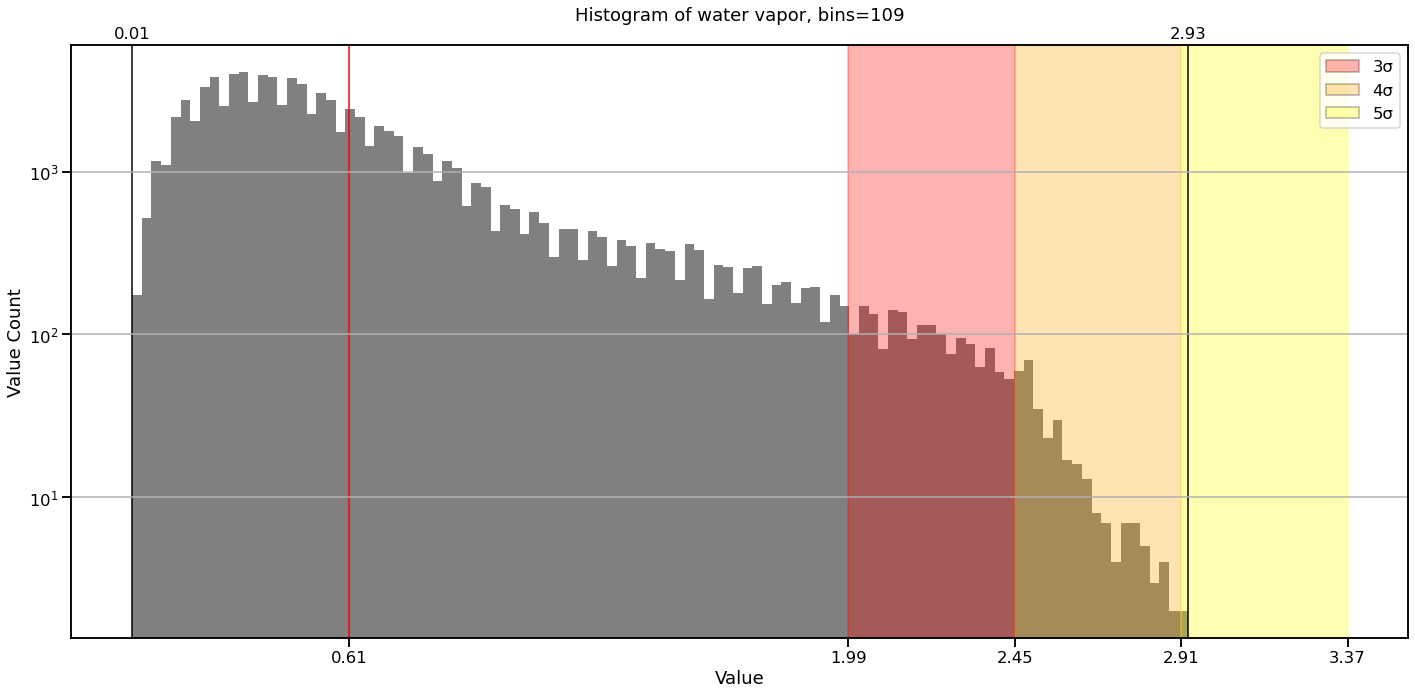


ANALYZING wind direction
The column is 100.00% dense, 91368 / 91368
The average distance between values is 0 days 00:35:09.952170915.
 Below is a graph showing the various differences in distances between values:



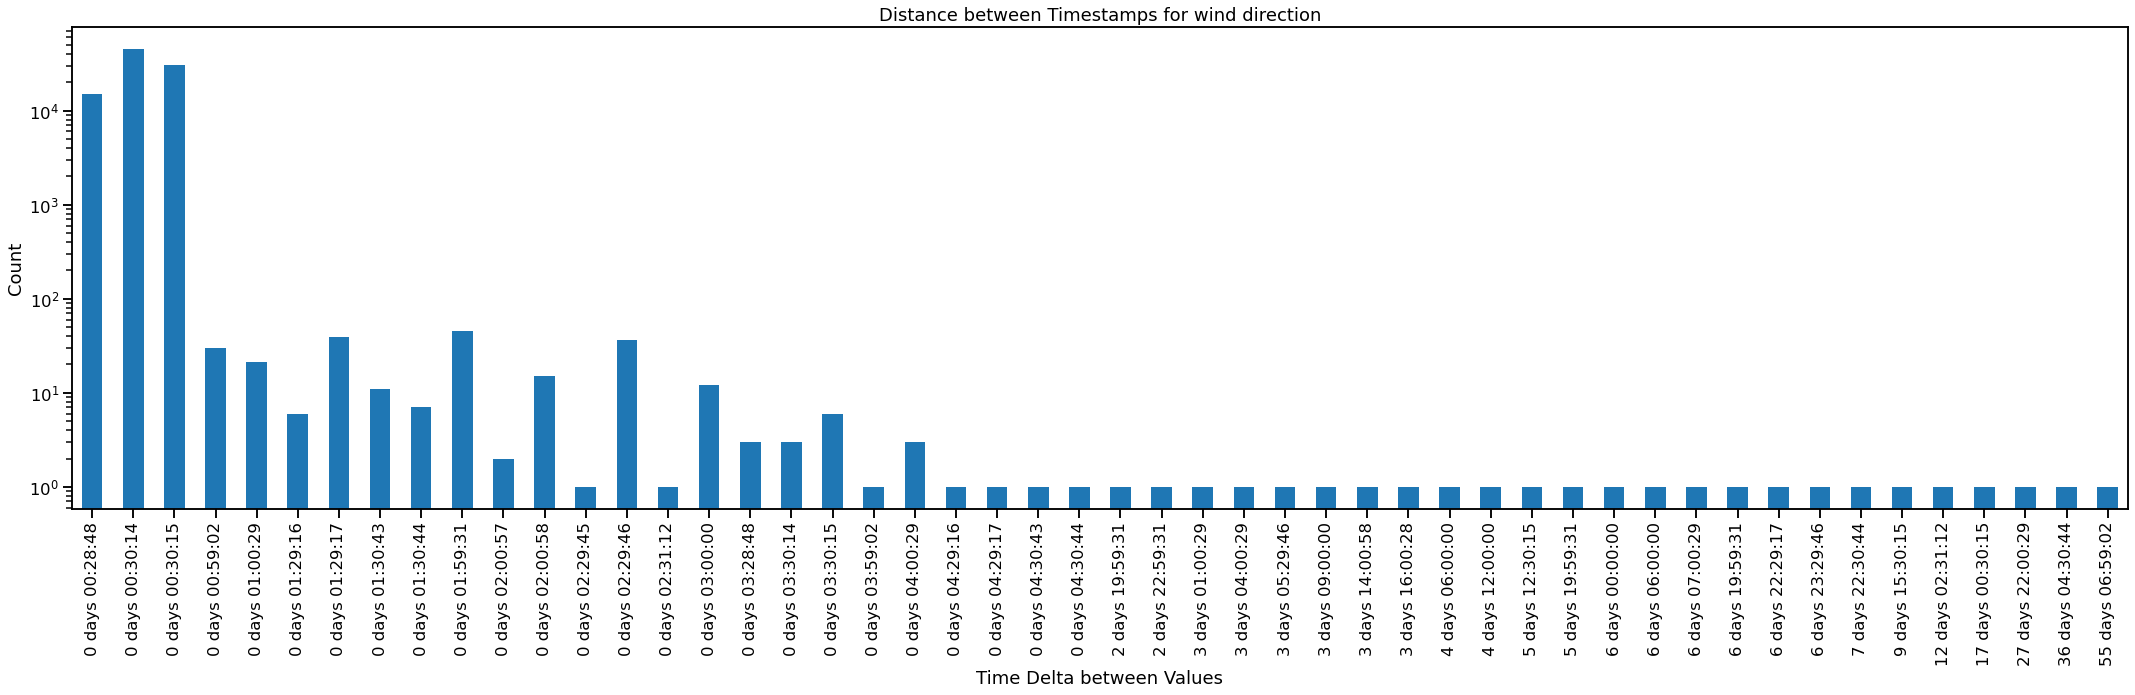


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

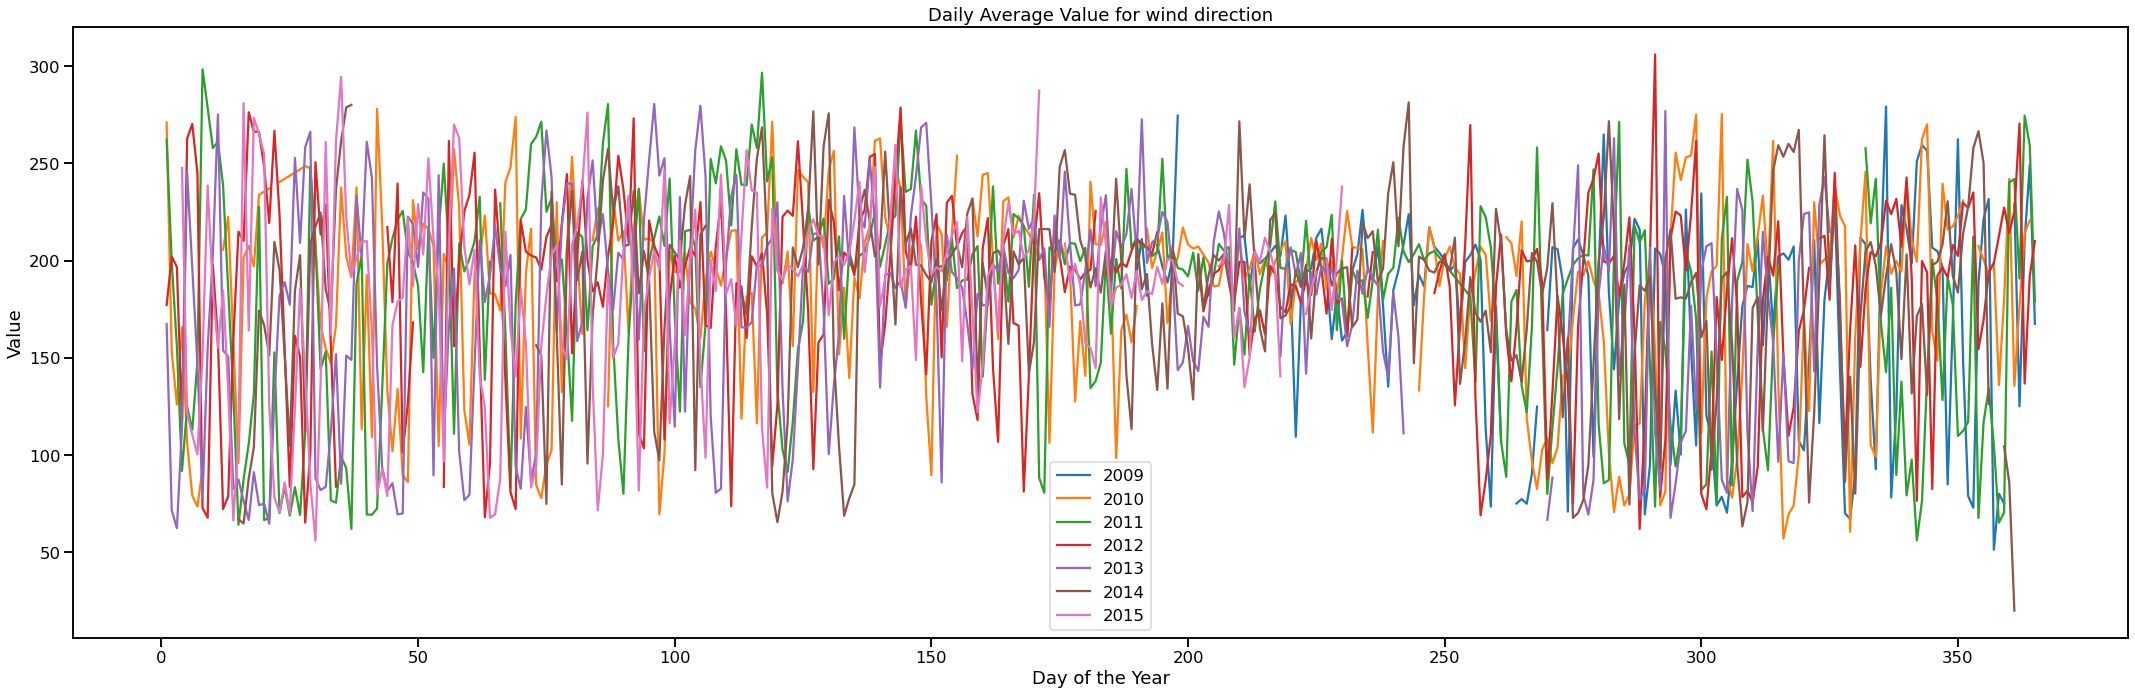


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


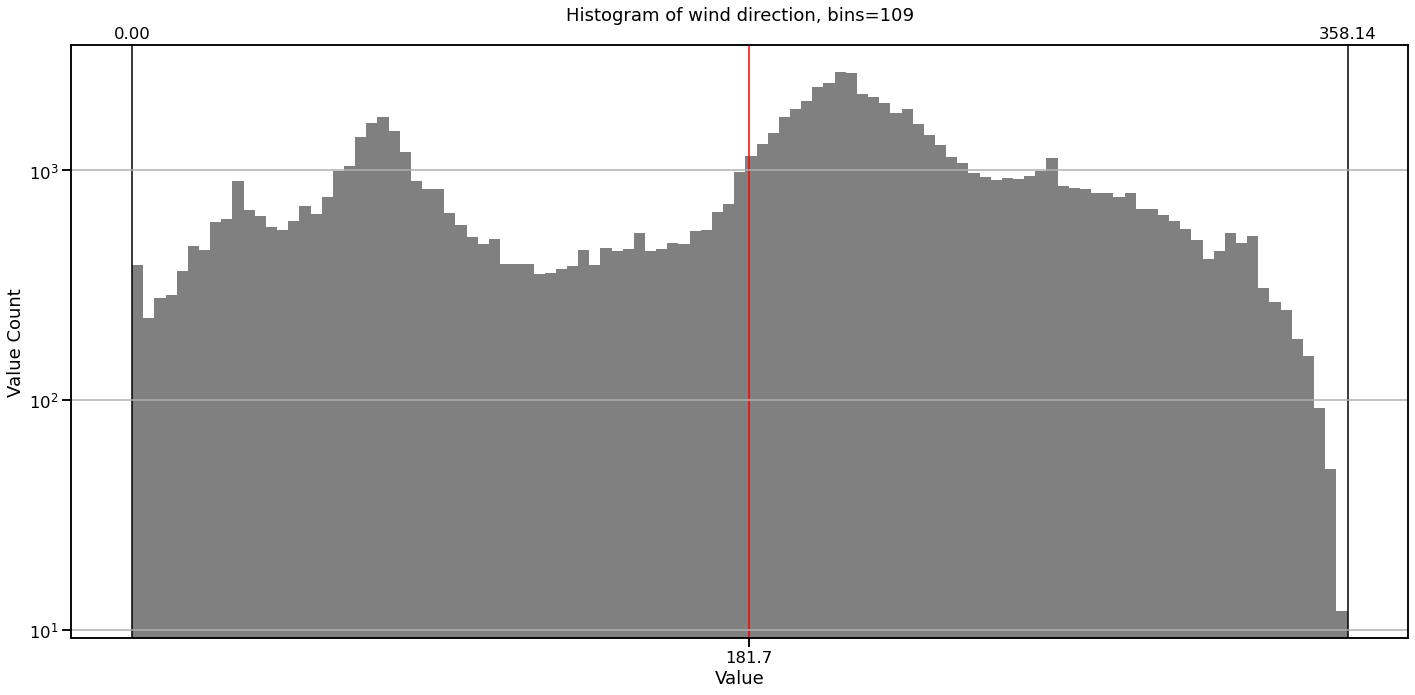


ANALYZING wind speed
The column is 100.00% dense, 91368 / 91368
The average distance between values is 0 days 00:35:09.952170915.
 Below is a graph showing the various differences in distances between values:



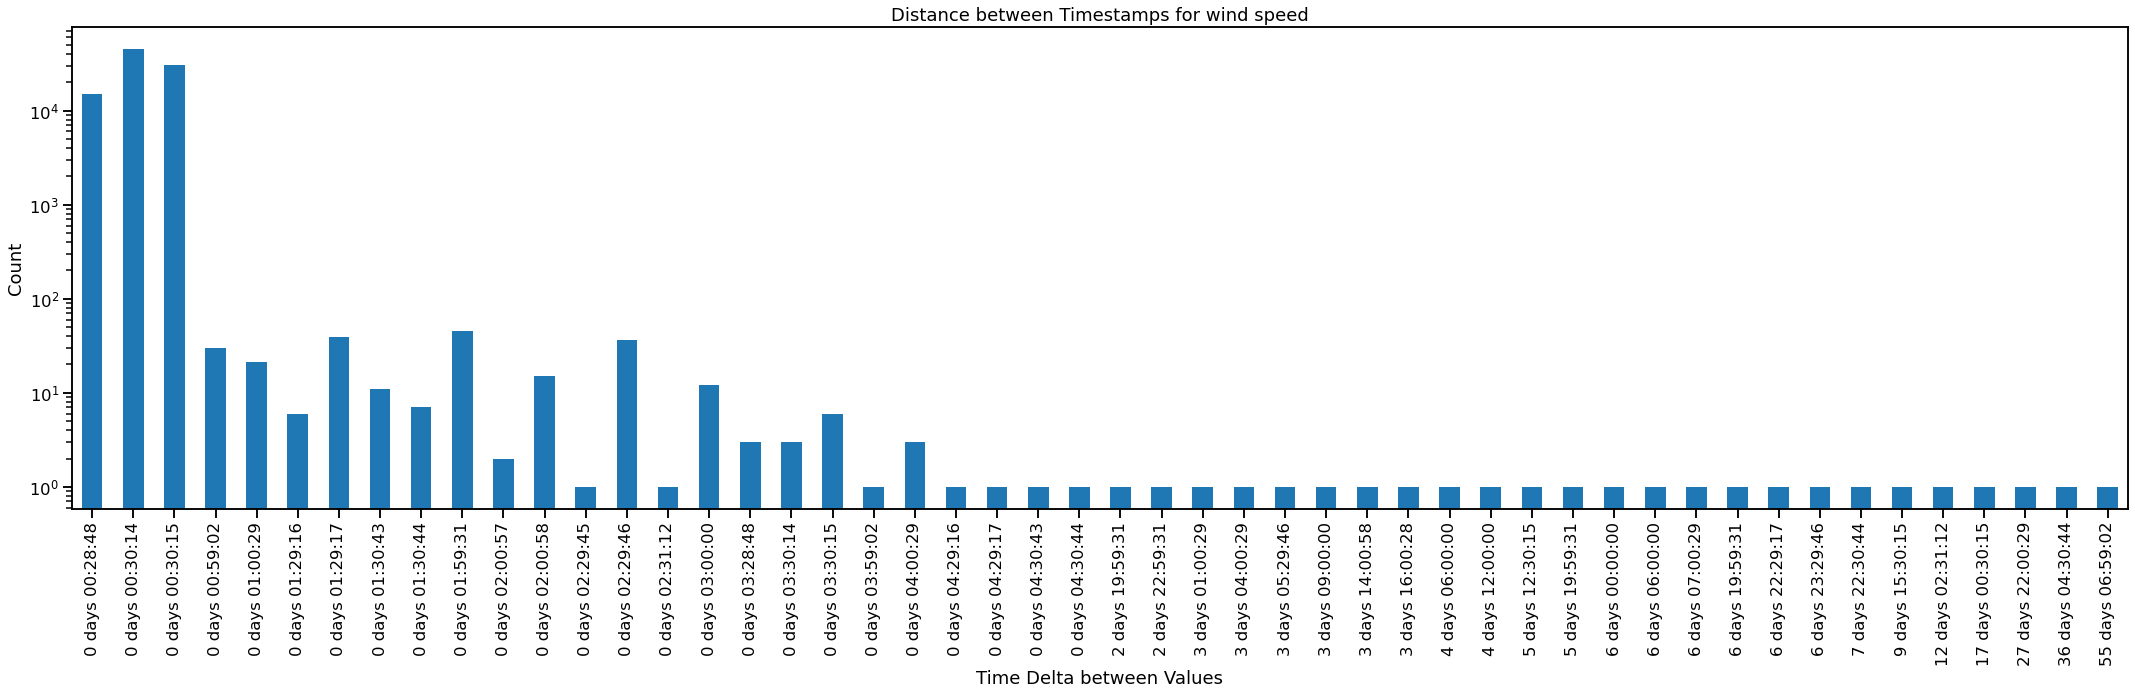


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

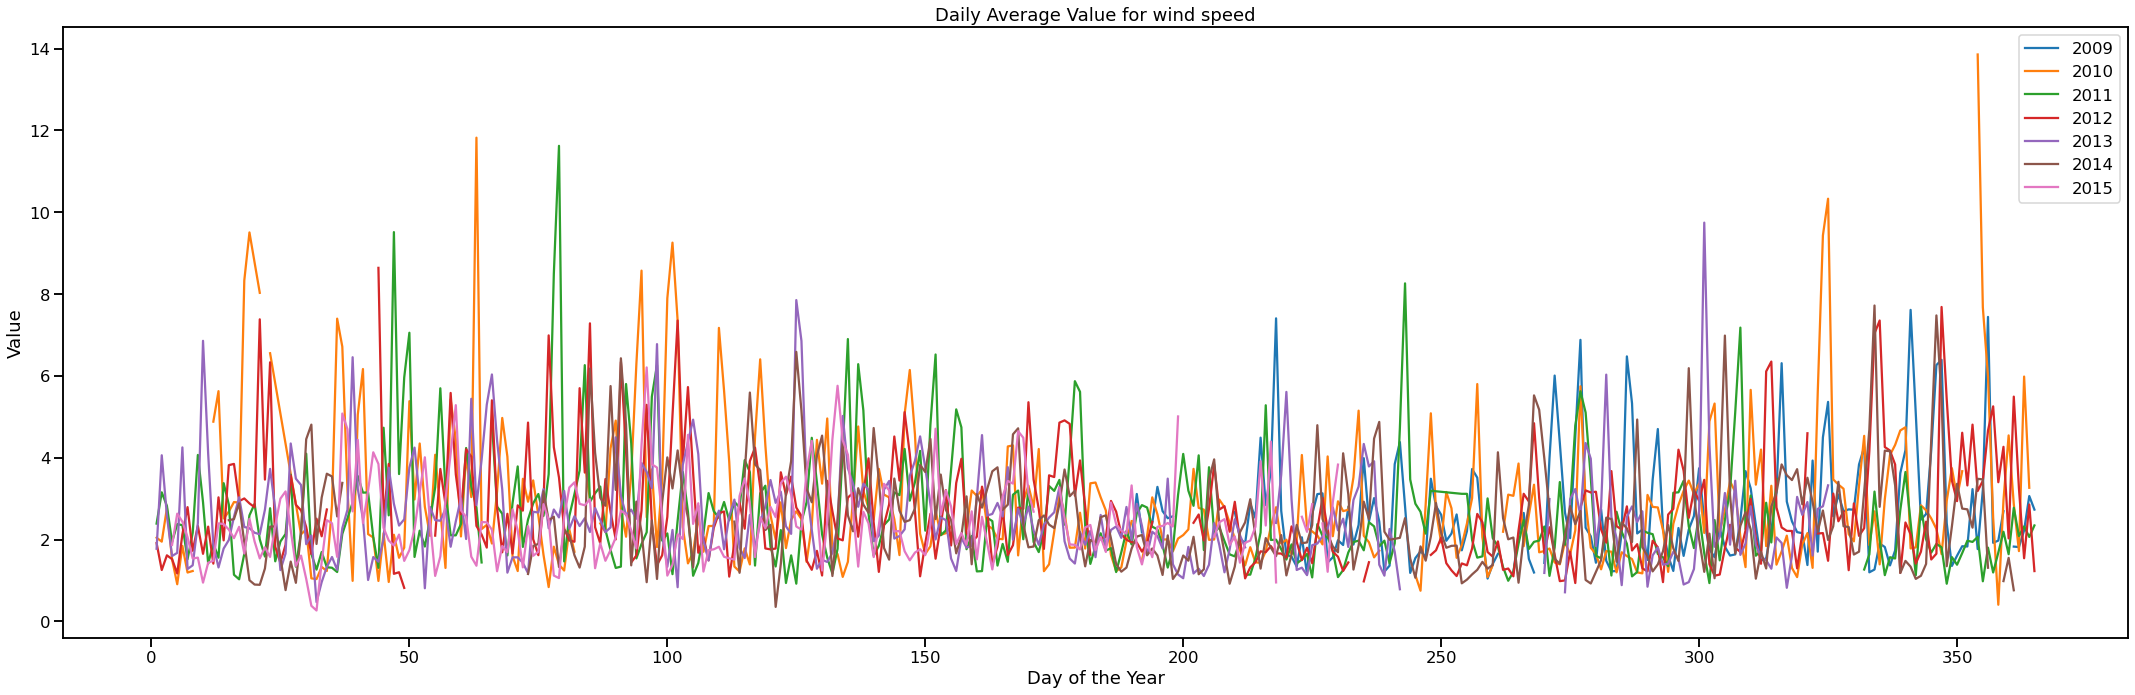


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


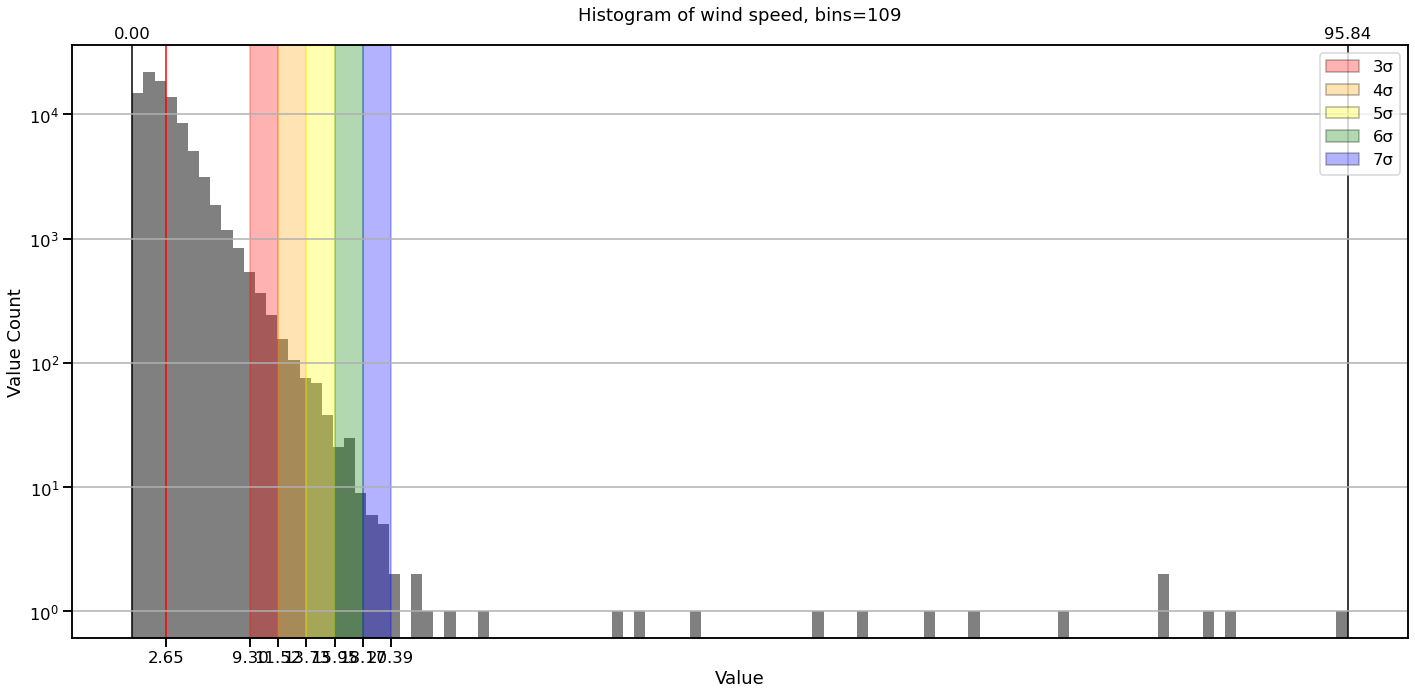


ANALYZING temperature
The column is 100.00% dense, 91368 / 91368
The average distance between values is 0 days 00:35:09.952170915.
 Below is a graph showing the various differences in distances between values:



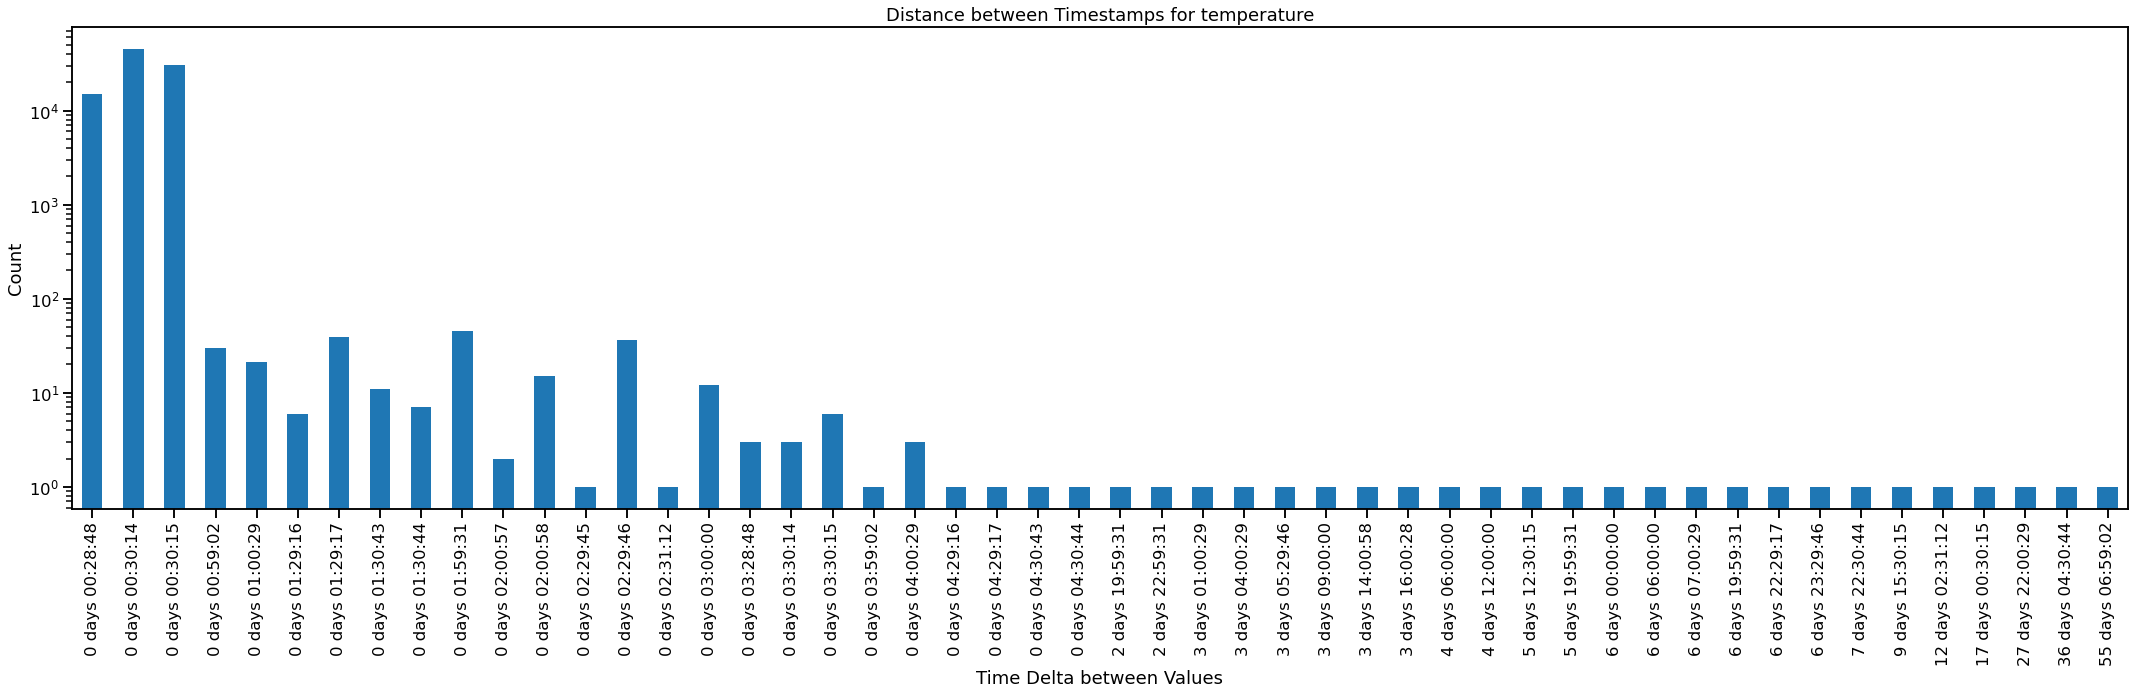


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

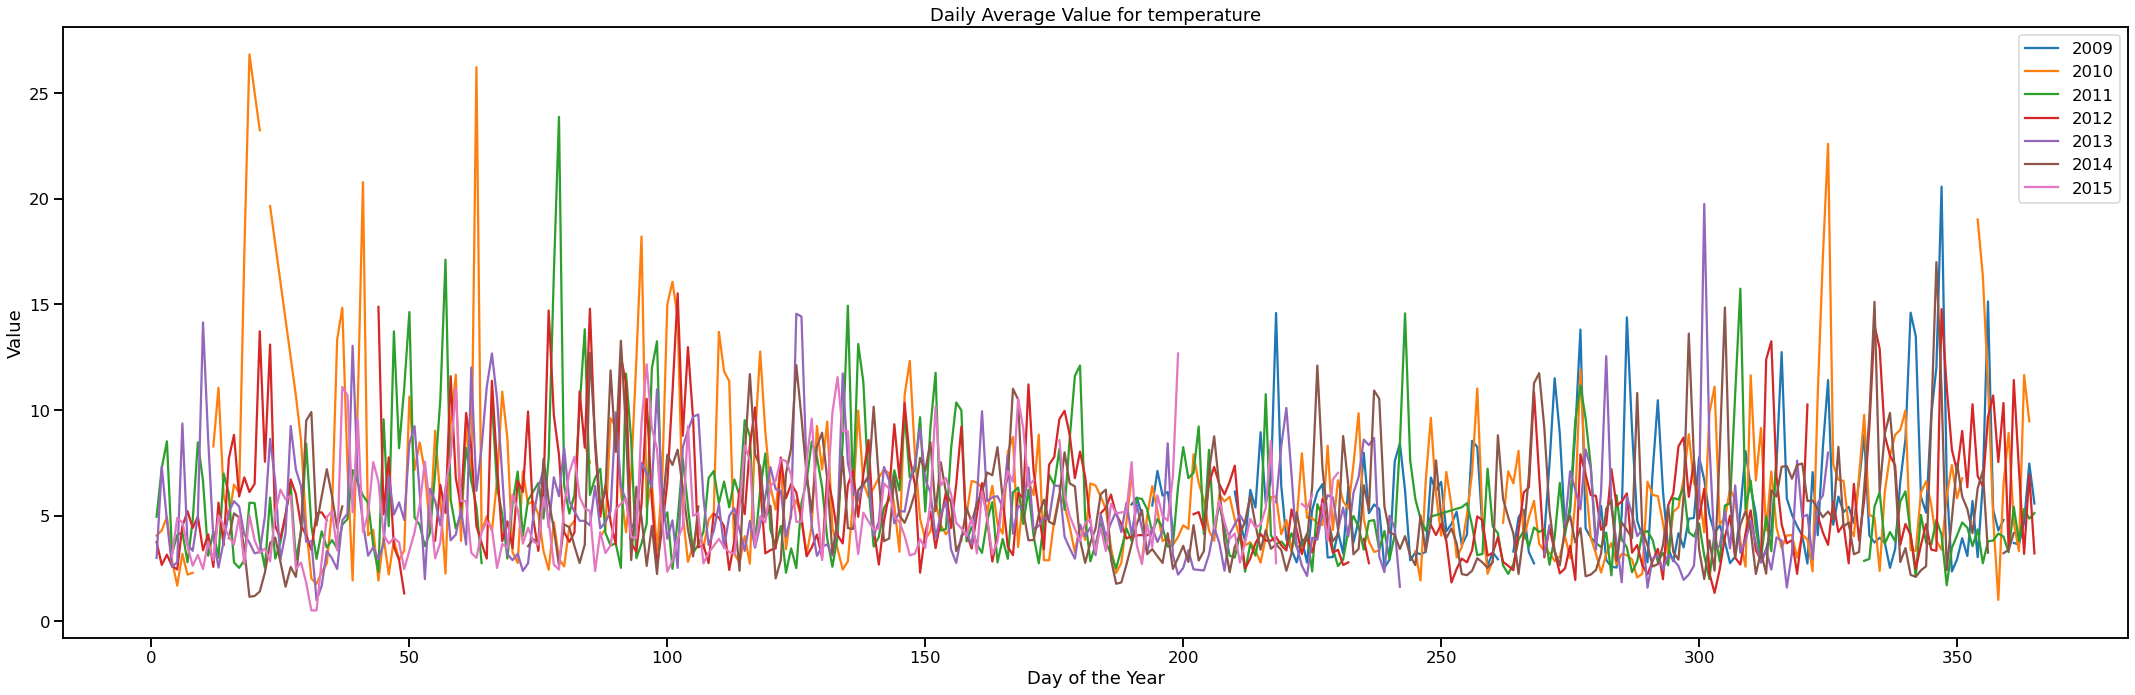


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


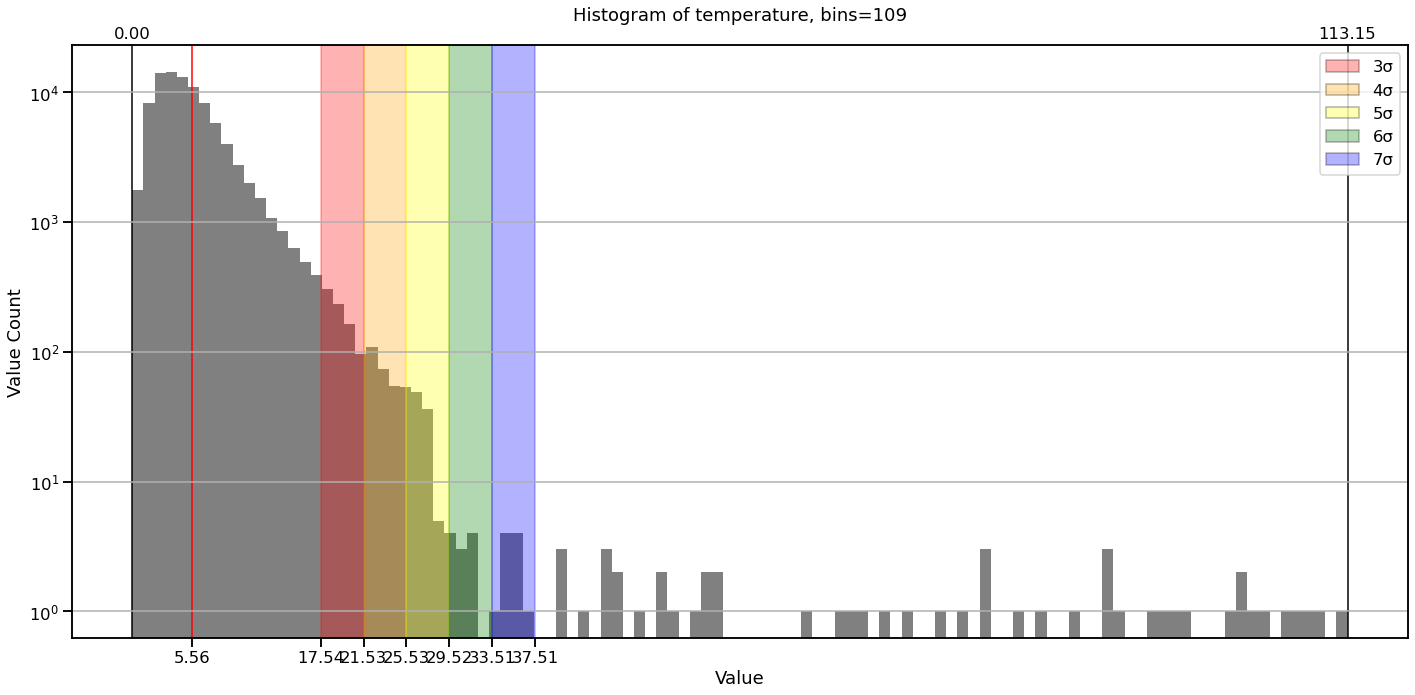


ANALYZING humidity
The column is 100.00% dense, 91368 / 91368
The average distance between values is 0 days 00:35:09.952170915.
 Below is a graph showing the various differences in distances between values:



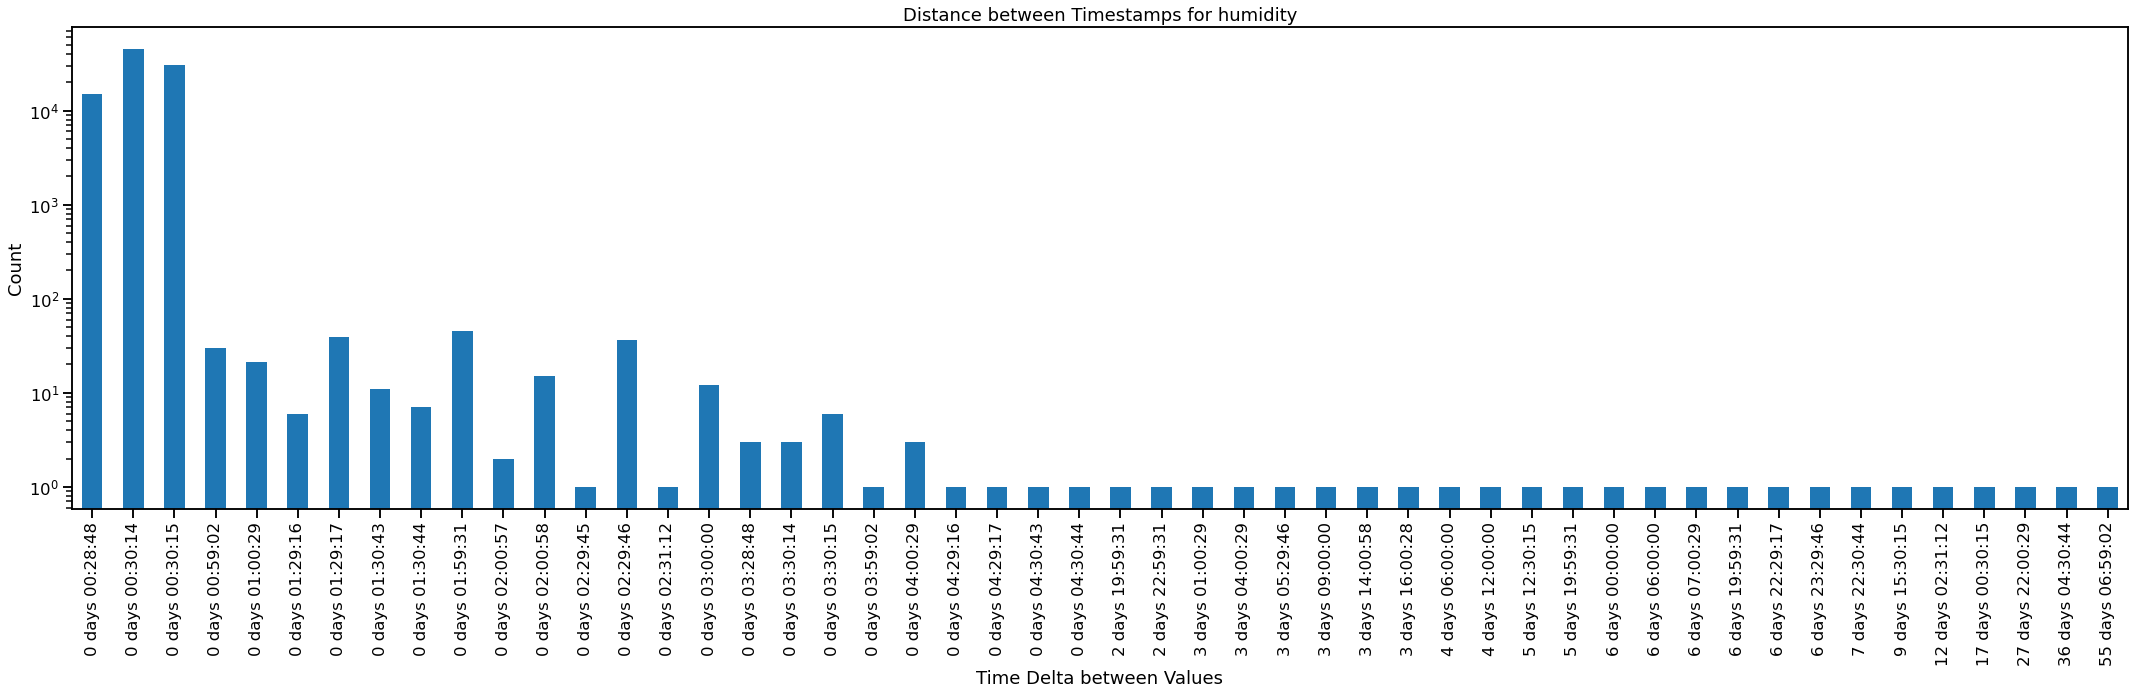


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

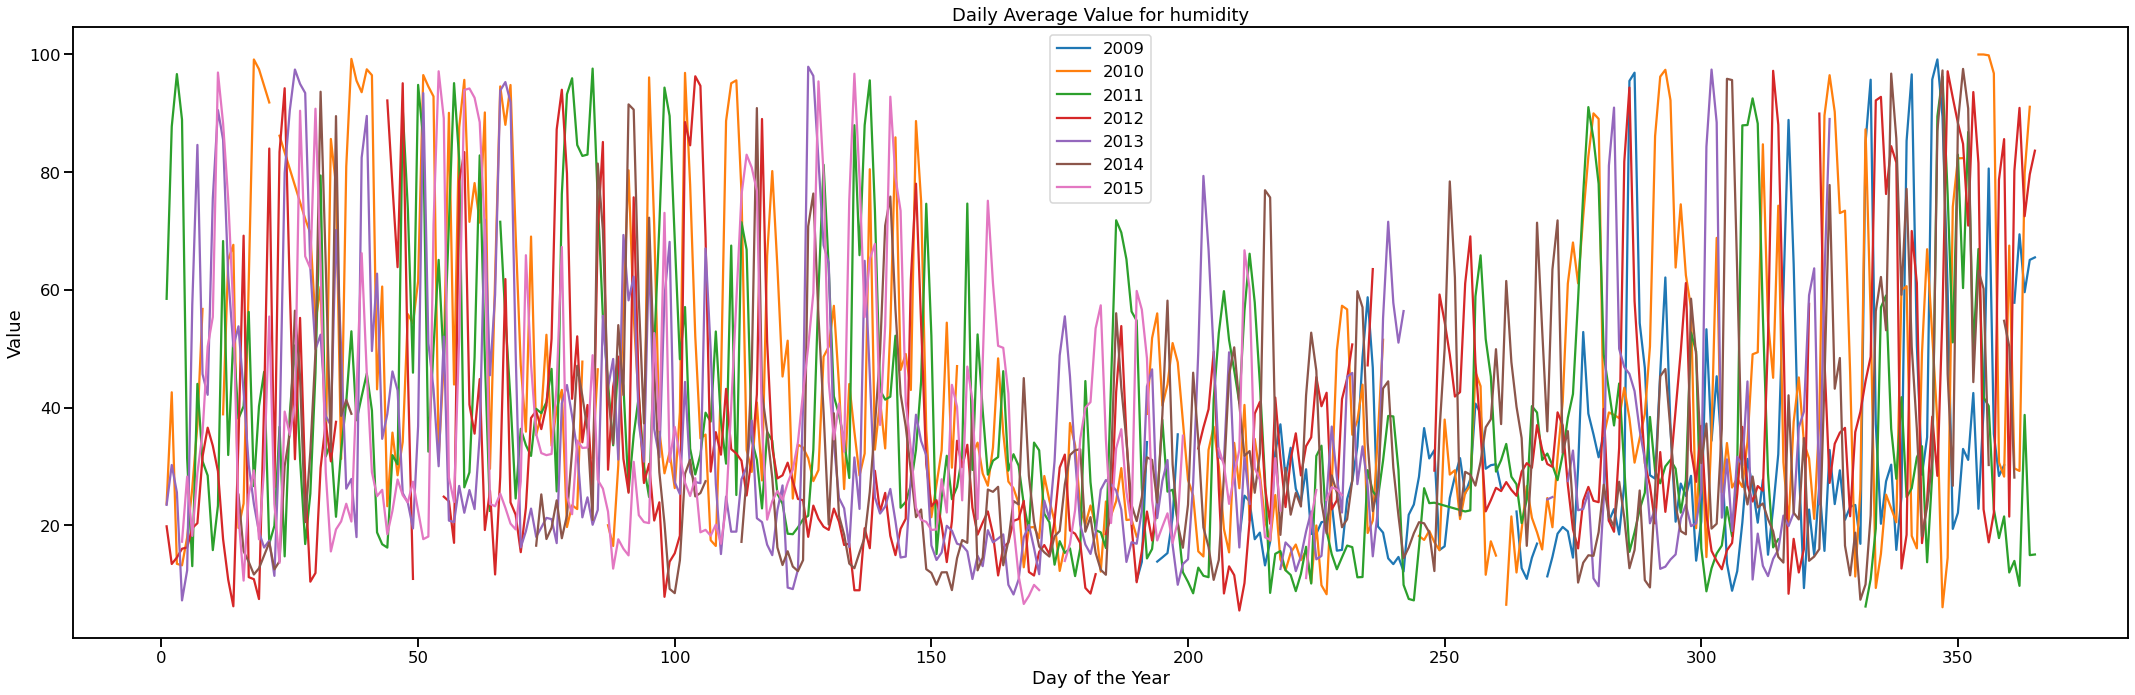


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


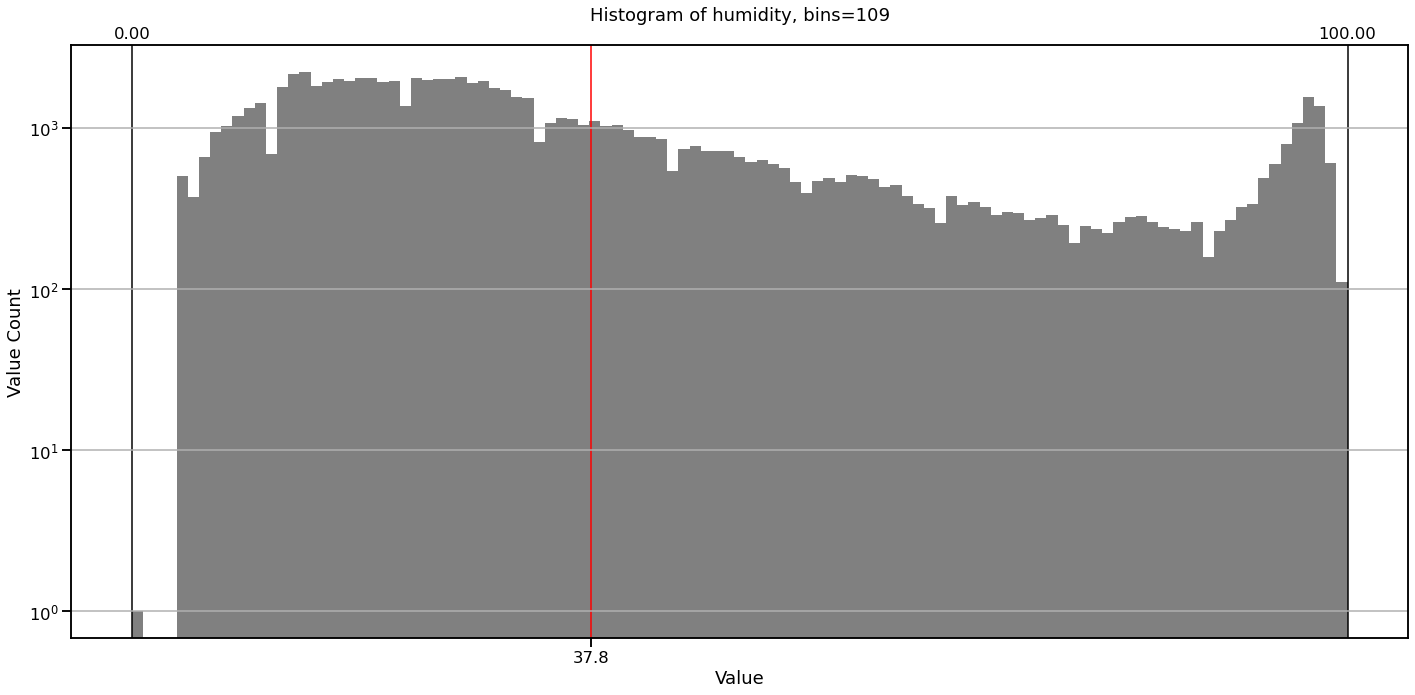


ANALYZING wind gust
The column is 100.00% dense, 91368 / 91368
The average distance between values is 0 days 00:35:09.952170915.
 Below is a graph showing the various differences in distances between values:



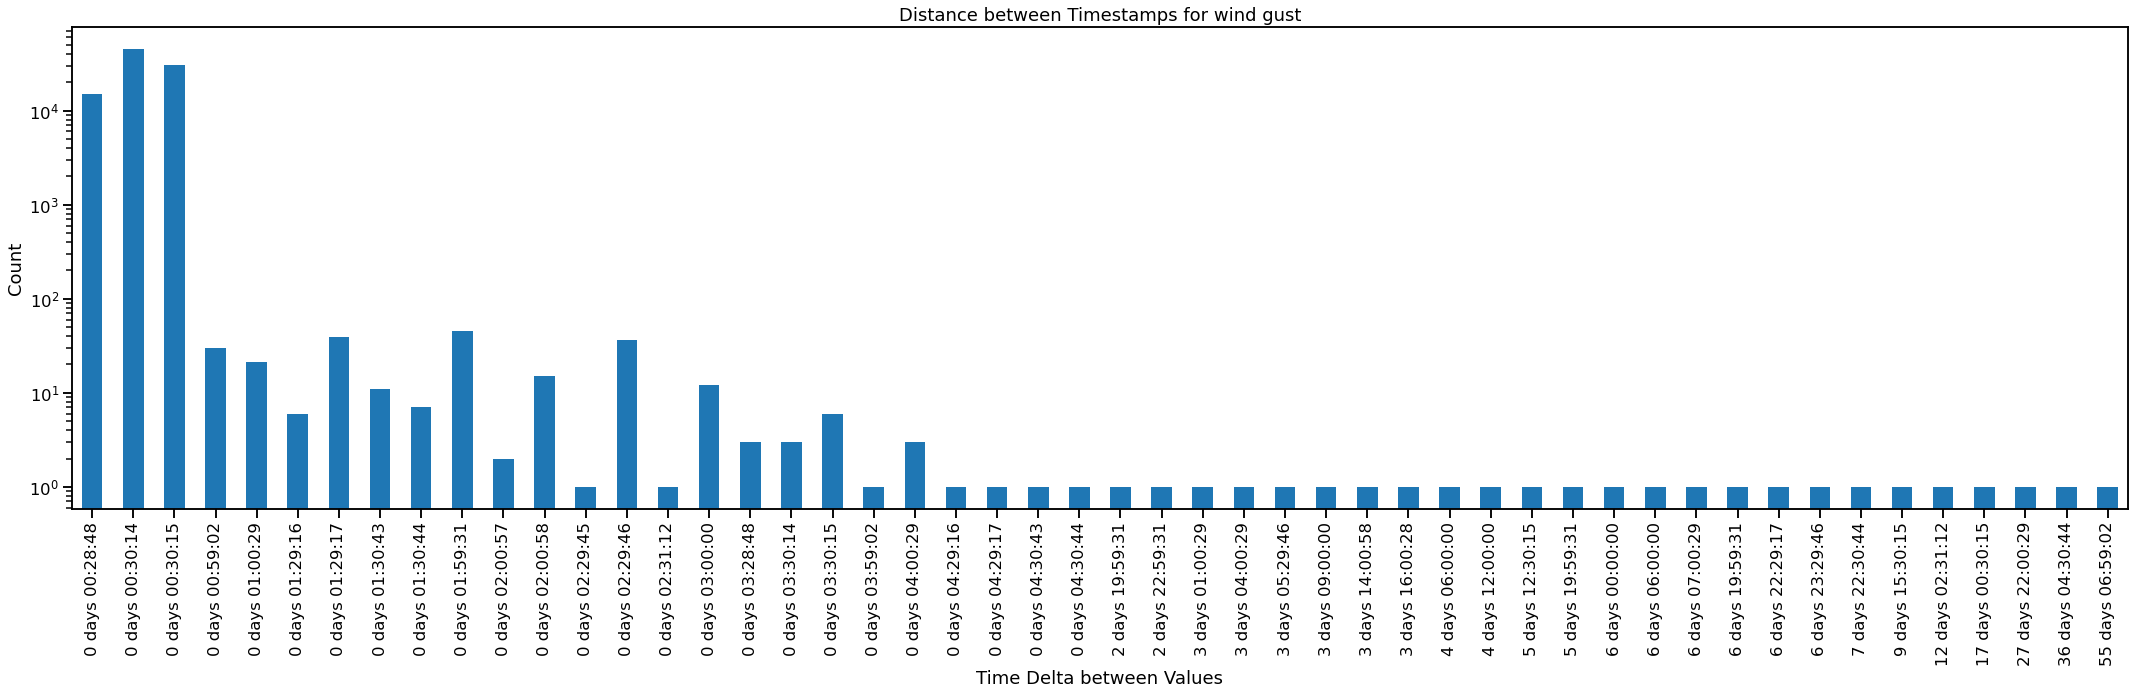


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

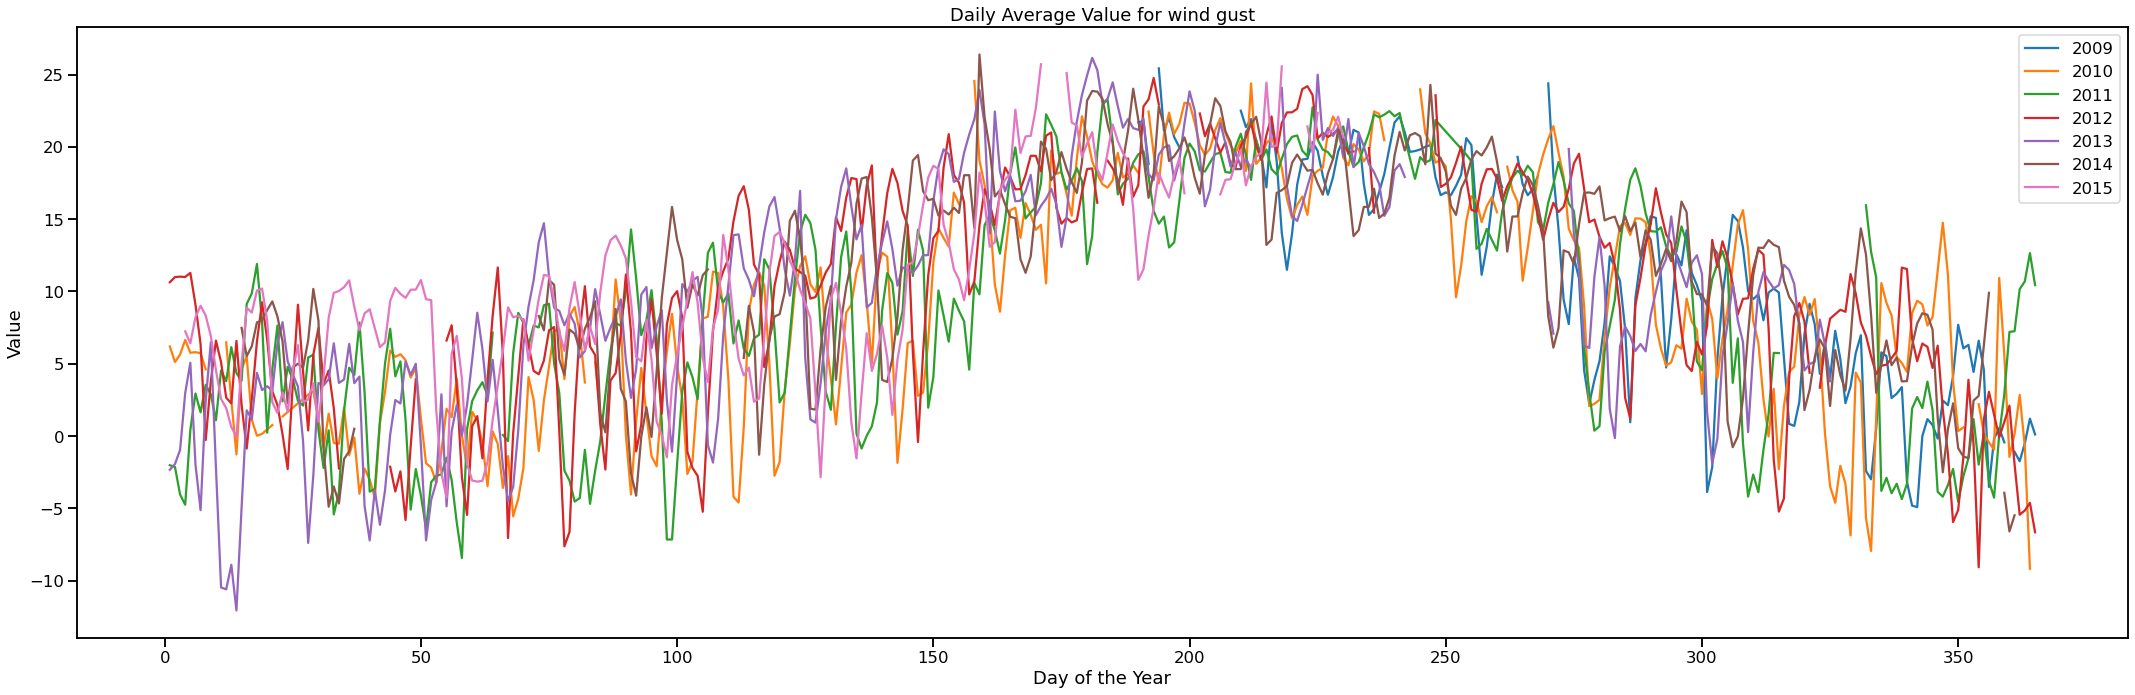


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


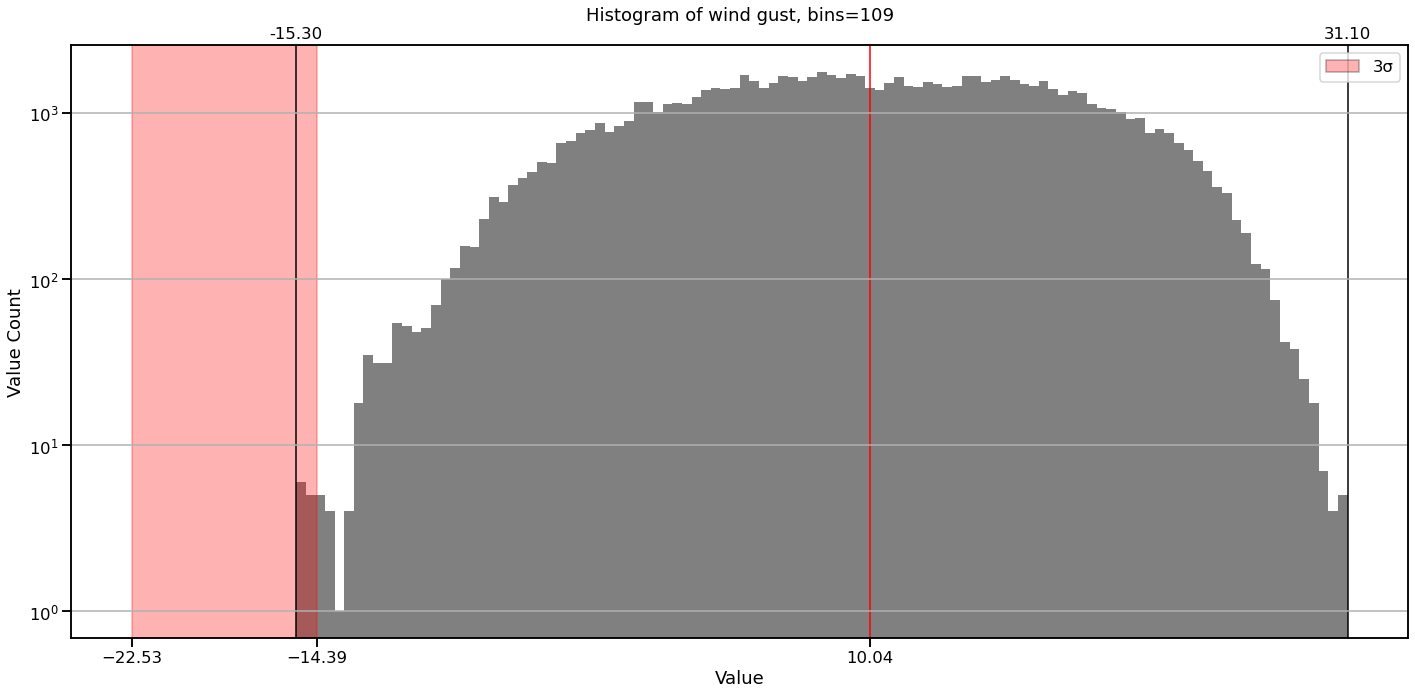


ANALYZING pressure
The column is 100.00% dense, 91368 / 91368
The average distance between values is 0 days 00:35:09.952170915.
 Below is a graph showing the various differences in distances between values:



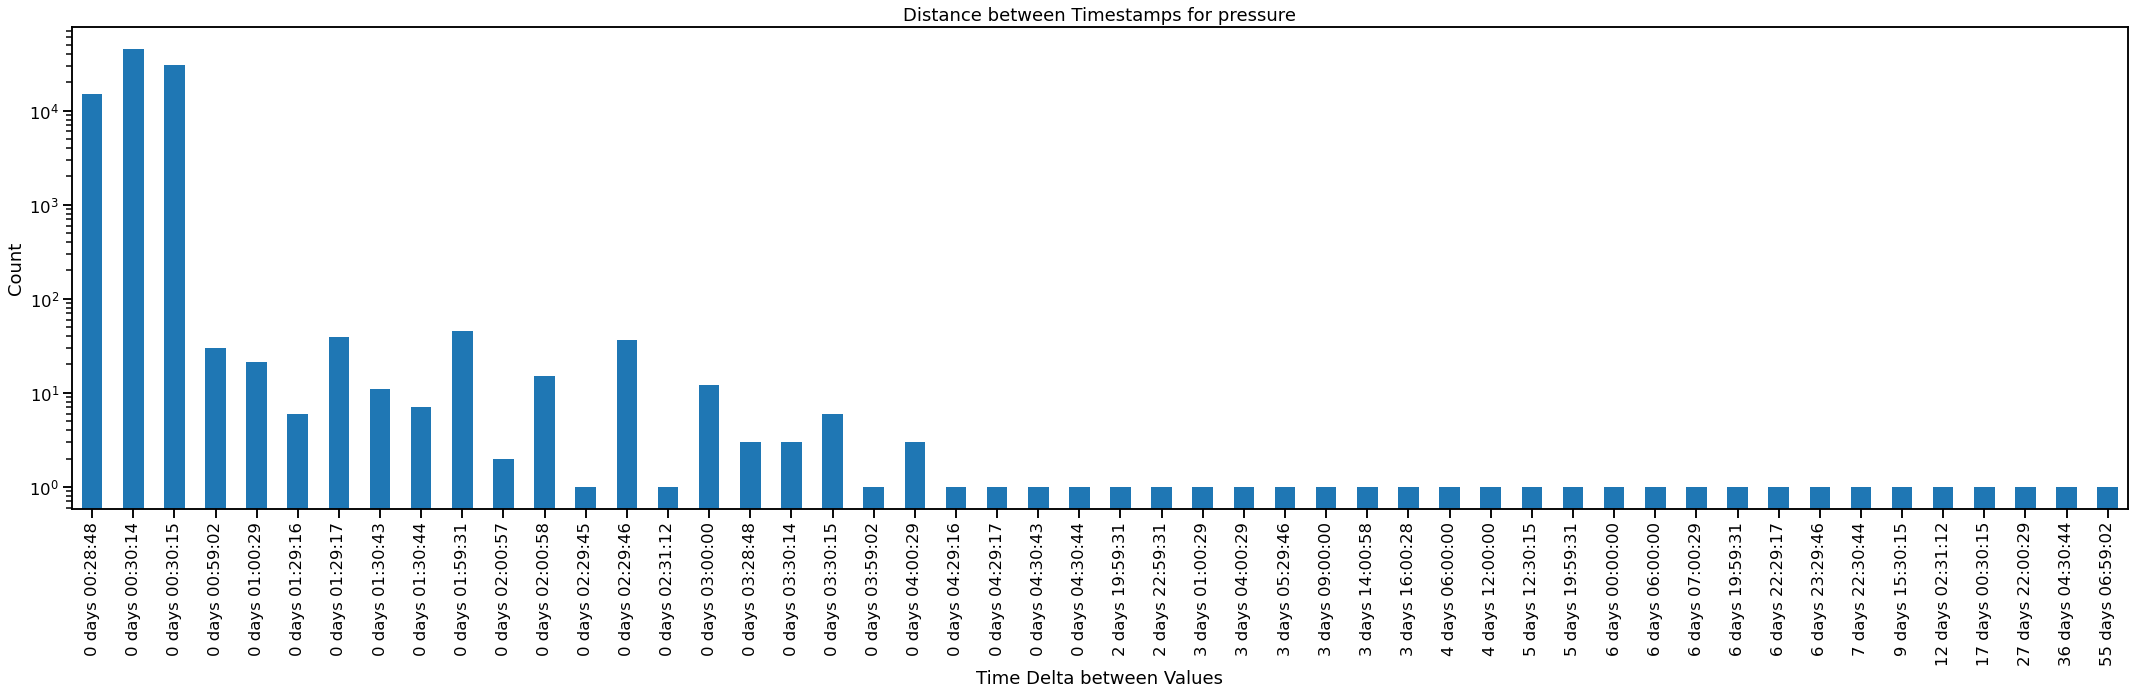


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

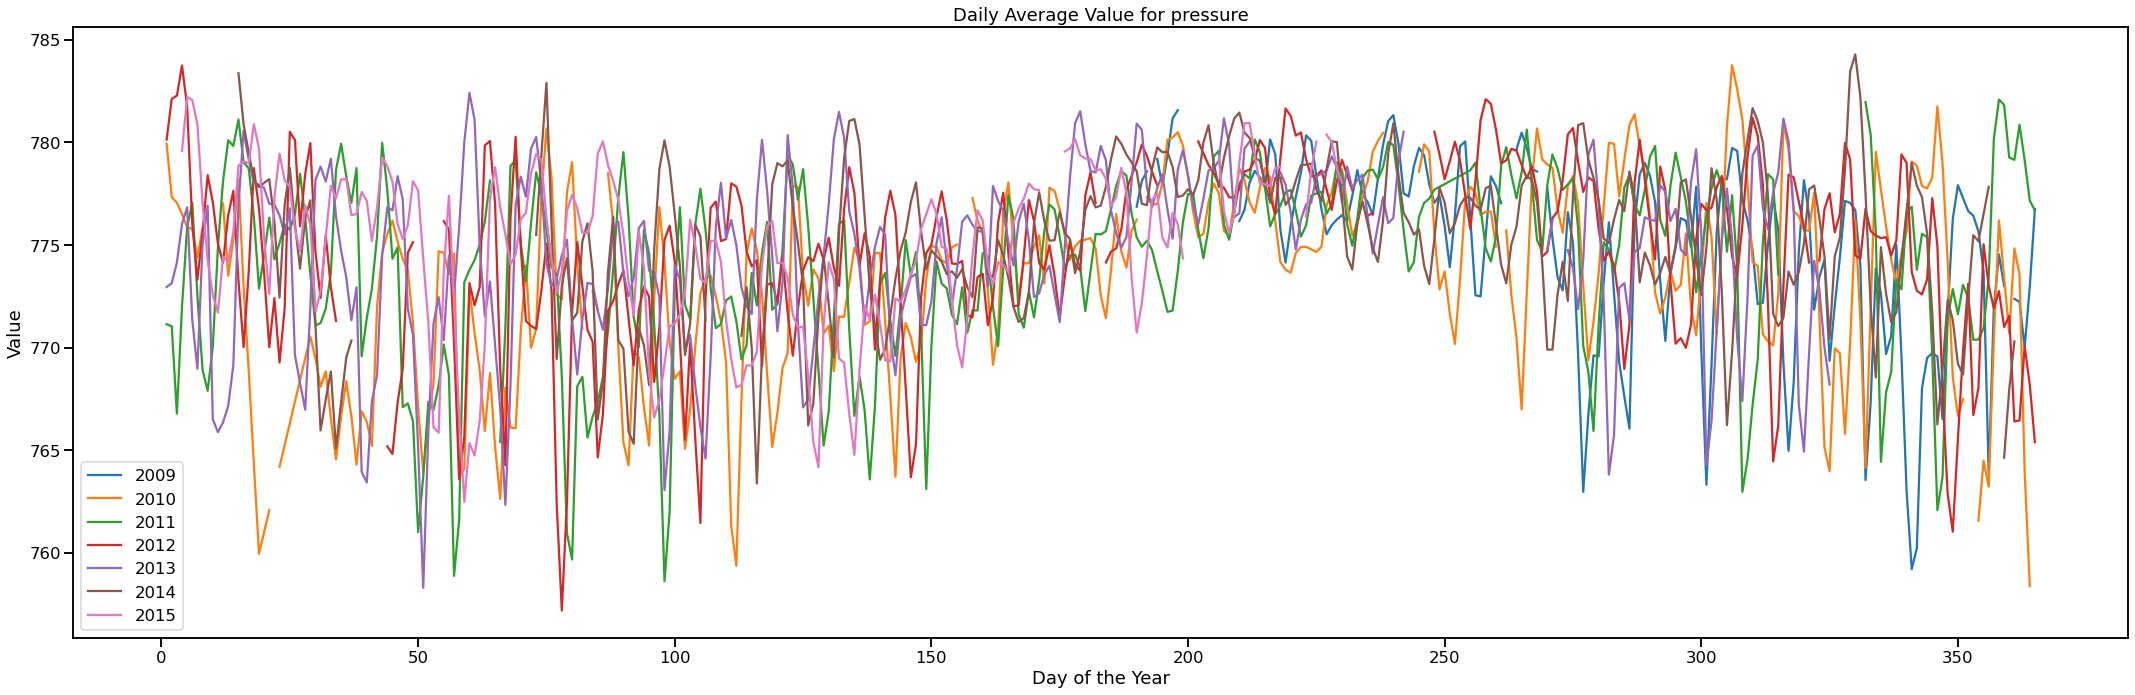


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


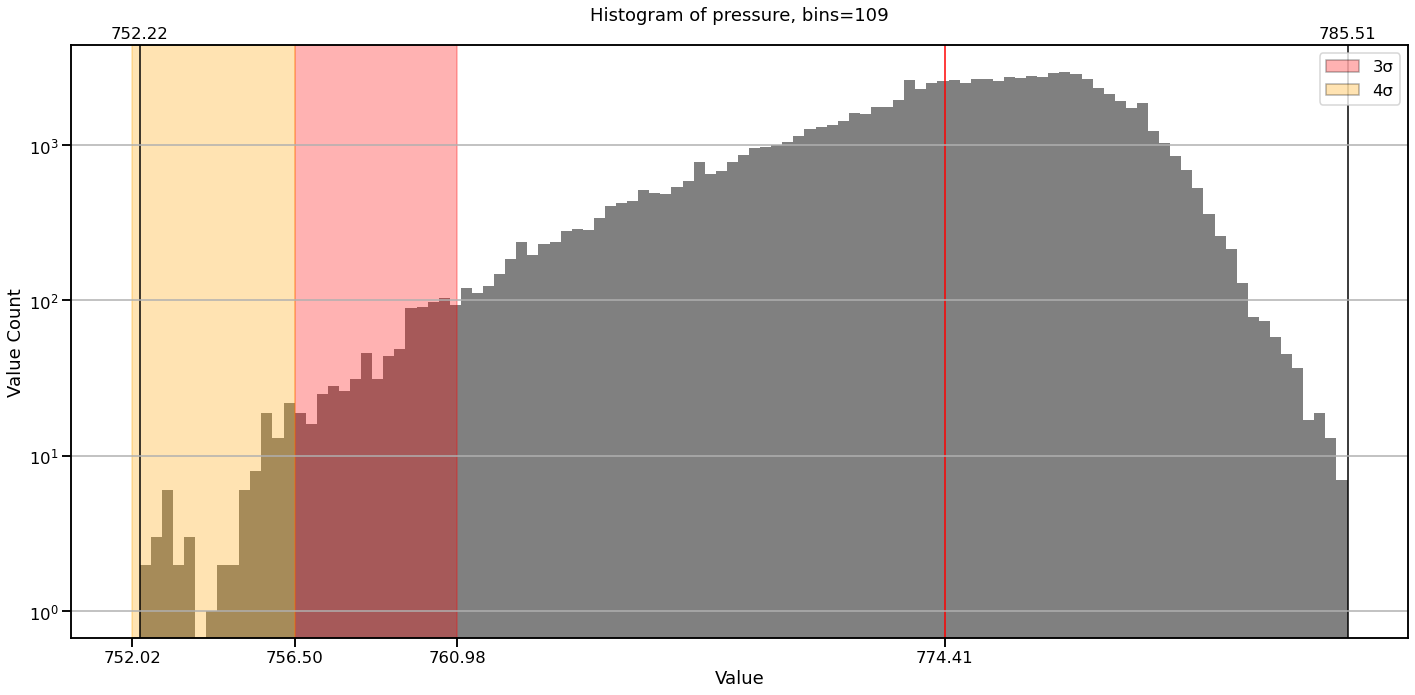


ANALYZING dewpoint
The column is 100.00% dense, 91367 / 91368
The average distance between values is 0 days 00:35:09.975264321.
 Below is a graph showing the various differences in distances between values:



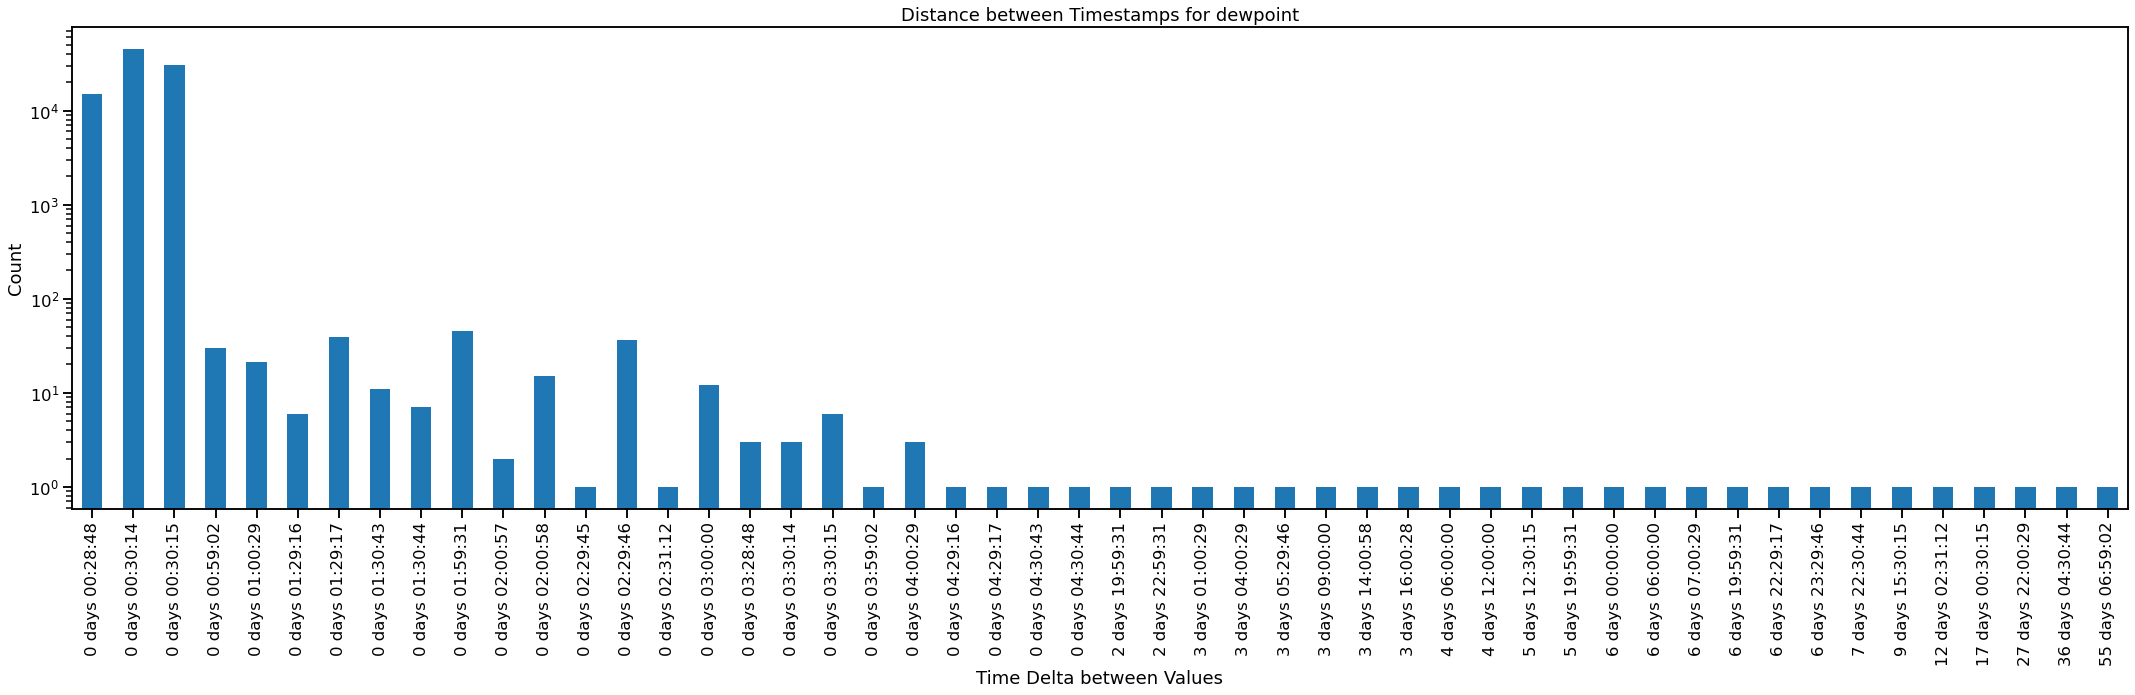


The following graph plots the daily average of each year:



<Figure size 432x288 with 0 Axes>

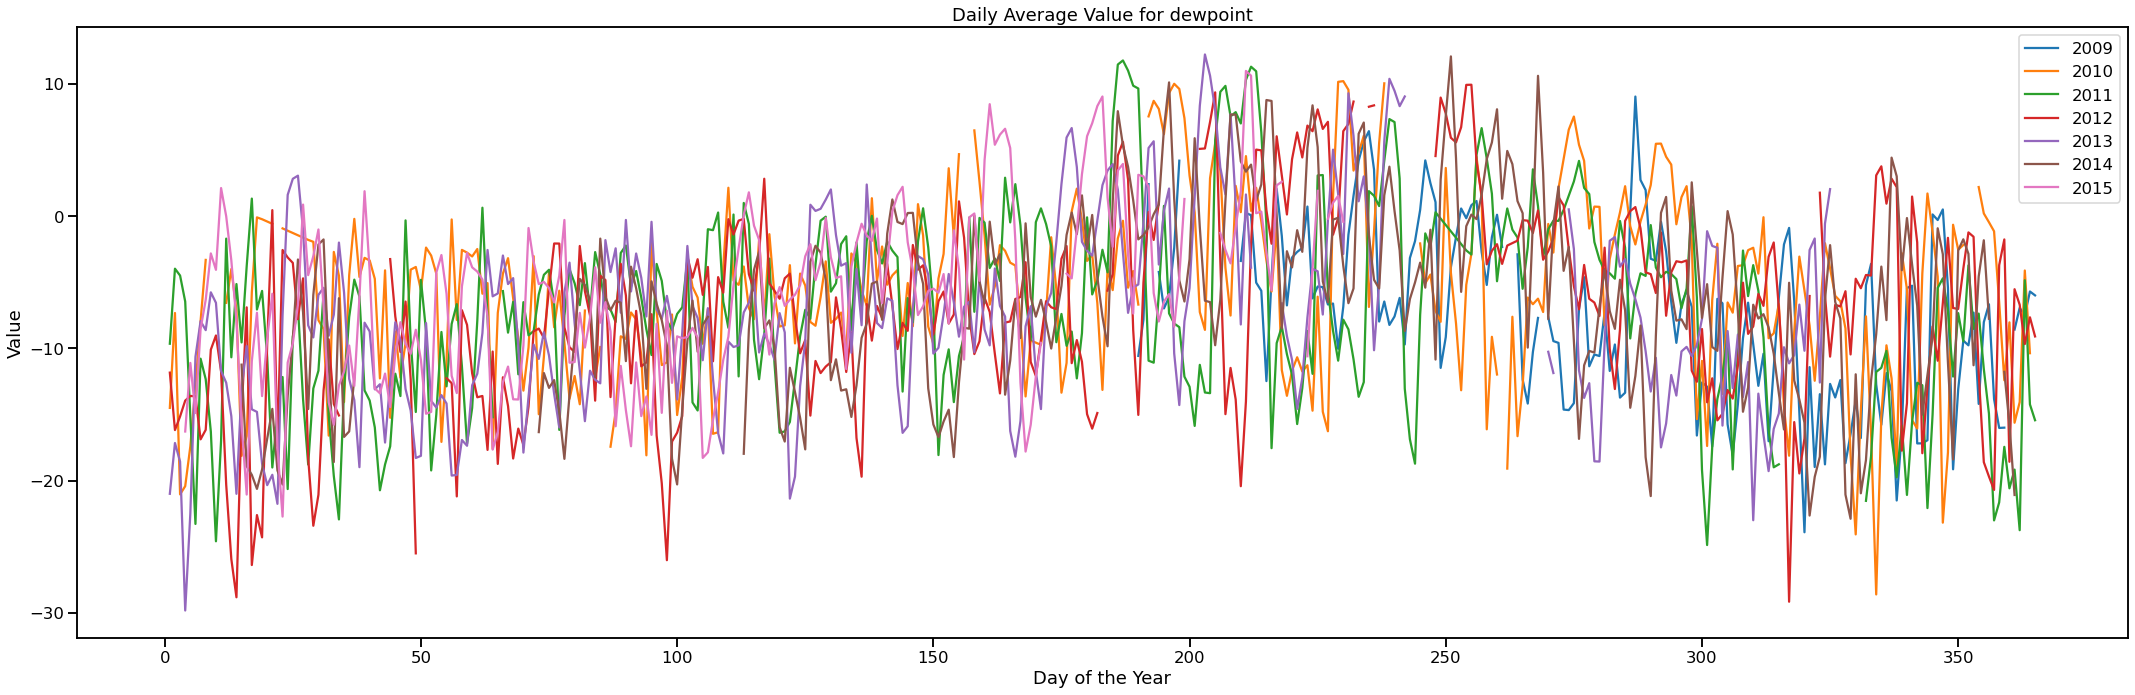


The follow graph is a histogram of the given column with the standard deviation regions away from the mean highlighted to show outliers.
The red vertical line is the mean of the column, and each highlighted region is N standard deviations away.
The lower x-axis mark the boundaries of these sigma regions. The upper x-axis mark the min/max values for the series.


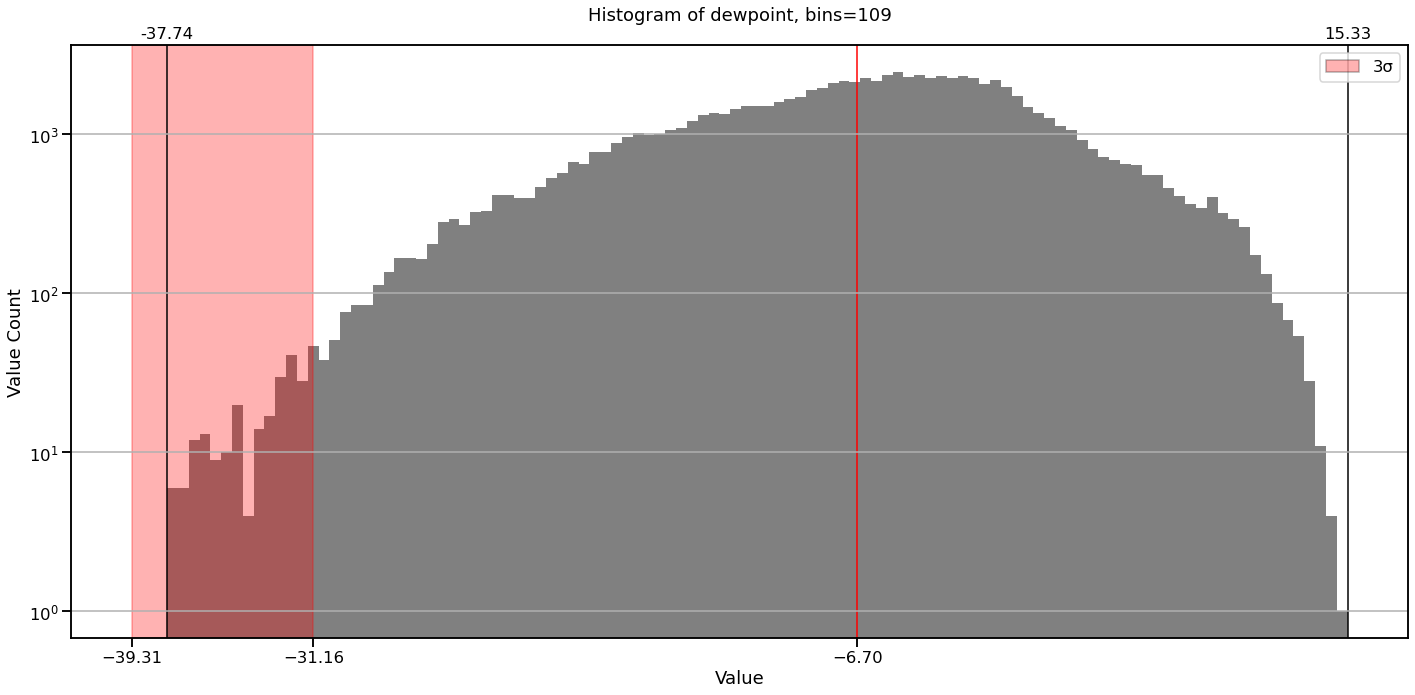

<Figure size 432x288 with 0 Axes>

In [5]:
stats = analyze(df, drop=True)

In [6]:
# This line checks if there's any duplicate index values in the dataframe
df[df.index.duplicated(keep=False)]

# This will show some of the column stats in a prettier format
pd.DataFrame(stats['columns'])

datenum                water vapor  \
percent                             100                        100   
total                             91368                      91368   
value count                       91368                      91368   
nan count                             0                          0   
cadence mean  0 days 00:35:09.952170915  0 days 00:35:09.952170915   

                         wind direction                 wind speed  \
percent                             100                        100   
total                             91368                      91368   
value count                       91368                      91368   
nan count                             0                          0   
cadence mean  0 days 00:35:09.952170915  0 days 00:35:09.952170915   

                            temperature                   humidity  \
percent                             100                        100   
total                             91368                      91368   
value count                       91368                      91368   
nan count                             0                          0   
cadence mean  0 days 00:35:09.952170915  0 days 00:35:09.952170915   

                              wind gust                   pressure  \
percent                             100                        100   
total                             91368                      91368   
value count                       91368                      91368   
nan count                             0                          0   
cadence mean  0 days 00:35:09.952170915  0 days 00:35:09.952170915   

                               dewpoint  
percent                         99.9989  
total                             91368  
value count                       91367  
nan count                             1  
cadence mean  0 days 00:35:09.975264321